## 第零步：准备工作，导入库，封装函数

In [1]:
'''
start: 2020-02-01 00:00:00
end: 2020-03-01 00:00:00
period: 1h
exchanges: [{"eid":"Huobi","currency":"BTC_USDT","stocks":0}]
'''
from __future__ import absolute_import, division, print_function
from fmz import * # 导入所有FMZ函数

#from pandas import *
import pandas as pd
import numpy as np

# Display and Plotting
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
#matplotlib.rcParams['axes.unicode_minus']=False # 解决负号显示异常的问题

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.graphics.api import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox as lb_test

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy import stats
# import arch
from arch import arch_model
import talib
import json
from urllib import request
from math import sqrt

from datetime import timedelta
from itertools import product
import warnings
warnings.simplefilter('ignore')

# %matplotlib inline
%config InlineBackend.figure_format = 'retina' # Increase chart resolution
task = VCtx(__doc__) # 初始化
print(exchange.GetAccount())
# print(exchange.GetTicker())
print(task.Join(True)) 

{'Balance': 10000.0, 'FrozenBalance': 0.0, 'Stocks': 0.0, 'FrozenStocks': 0.0}
                           close  balance  stocks  fee  net
2020-02-01 00:00:00+08:00    NaN  10000.0     0.0  0.0  NaN
2020-02-01 01:00:00+08:00    NaN  10000.0     0.0  0.0  NaN
2020-02-01 02:00:00+08:00    NaN  10000.0     0.0  0.0  NaN
2020-02-01 03:00:00+08:00    NaN  10000.0     0.0  0.0  NaN
2020-02-01 04:00:00+08:00    NaN  10000.0     0.0  0.0  NaN
2020-02-01 05:00:00+08:00    NaN  10000.0     0.0  0.0  NaN
2020-02-01 06:00:00+08:00    NaN  10000.0     0.0  0.0  NaN
2020-02-01 07:00:00+08:00    NaN  10000.0     0.0  0.0  NaN
2020-02-01 08:00:00+08:00    NaN  10000.0     0.0  0.0  NaN
2020-02-01 09:00:00+08:00    NaN  10000.0     0.0  0.0  NaN
2020-02-01 10:00:00+08:00    NaN  10000.0     0.0  0.0  NaN
2020-02-01 11:00:00+08:00    NaN  10000.0     0.0  0.0  NaN
2020-02-01 12:00:00+08:00    NaN  10000.0     0.0  0.0  NaN
2020-02-01 13:00:00+08:00    NaN  10000.0     0.0  0.0  NaN
2020-02-01 14:00:00+0

In [55]:
# from catalyst import run_algorithm
# 绘图函数
def pacfplot(y, lags=None, figsize=(18, 8)):
    fig = plt.figure(figsize=figsize)

    acf_ax = fig.add_subplot(2,1,1)  # ACF
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    plt.grid()

    pacf_ax = fig.add_subplot(2,1,2)  # PACF
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.grid()
    
    sns.despine()
    plt.tight_layout()
    return acf_ax, pacf_ax

# 性能评价
def get_rmse(y, y_hat):
    '''Root Mean Square Error
    https://en.wikipedia.org/wiki/Root-mean-square_deviation
    '''
    mse = np.mean((y - y_hat)**2)
    return np.sqrt(mse)

def get_mape(y, y_hat):
    '''Mean Absolute Percent Error
    https://en.wikipedia.org/wiki/Mean_absolute_percentage_error
    '''
    perc_err = (100*(y - y_hat))/y
    return np.mean(abs(perc_err))

def get_mase(y, y_hat):
    '''Mean Absolute Scaled Error
    https://en.wikipedia.org/wiki/Mean_absolute_scaled_error
    '''
    abs_err = abs(y - y_hat)
    dsum=sum(abs(y[1:] - y_hat[1:]))
    t = len(y)
    denom = (1/(t - 1))* dsum
    return np.mean(abs_err/denom)

def mae(observation, forecast):    
    error = mean_absolute_error(observation, forecast)
    print('Mean Absolute Error (MAE): {:.3g}'.format(error))
    return error

def mape(observation, forecast): 
    observation, forecast = np.array(observation), np.array(forecast)
    # Might encounter division by zero error when observation is zero
    error = np.mean(np.abs((observation - forecast) / observation)) * 100
    print('Mean Absolute Percentage Error (MAPE): {:.3g}'.format(error))
    return error

def rmse(observation, forecast):
    error = sqrt(mean_squared_error(observation, forecast))
    print('Root Mean Square Error (RMSE): {:.3g}'.format(error))
    return error

def evaluate(pd_dataframe, observation, forecast):
    first_valid_date = pd_dataframe[forecast].first_valid_index()
    mae_error = mae(pd_dataframe[observation].loc[first_valid_date:, ], pd_dataframe[forecast].loc[first_valid_date:, ])
    mape_error = mape(pd_dataframe[observation].loc[first_valid_date:, ], pd_dataframe[forecast].loc[first_valid_date:, ])
    rmse_error = rmse(pd_dataframe[observation].loc[first_valid_date:, ], pd_dataframe[forecast].loc[first_valid_date:, ]) 

    ax = pd_dataframe.loc[:, [observation, forecast]].plot(figsize=(18,5))
    ax.xaxis.label.set_visible(False)
    return

## 第零点五步：数据准备

In [29]:
count_num = 100000
start_date = '2020-03-01'

df = get_bars('huobi.btc_usdt', '1m', count=count_num, start=start_date)  # 取分钟数据
kline_1m = pd.DataFrame(df['close'], dtype=np.float)
kline_1m.index.name = 'date'
kline_1m['log_price'] = np.log(kline_1m['close'])
kline_1m['return'] = kline_1m['close'].pct_change().dropna()
kline_1m['log_return'] = kline_1m['log_price'] - kline_1m['log_price'].shift(1)

kline_1m['squared_log_return'] = np.power(kline_1m['log_return'], 2)

kline_1m['return_100x'] = np.multiply(kline_1m['return'], 100)
kline_1m['log_return_100x'] = np.multiply(kline_1m['log_return'], 100)  # 放大100倍

##
df = get_bars('huobi.btc_usdt', '1h', count=count_num, start=start_date)  # 取小时数据
kline_test = pd.DataFrame(df['close'], dtype=np.float)
kline_test.index.name = 'date'
kline_test['log_price'] = np.log(kline_test['close'])  # 计算每日对数收益率
kline_test['return'] = kline_test['log_price'].pct_change().dropna()
kline_test['log_return'] = kline_test['log_price'] - kline_test['log_price'].shift(1)  # 计算对数收益率
kline_test['squared_log_return'] = np.power(kline_test['log_return'], 2)  # 对数日收益率的指数平方

kline_test['return_100x'] = np.multiply(kline_test['return'], 100)
kline_test['log_return_100x'] = np.multiply(kline_test['log_return'], 100)  # 放大100倍

kline_test['realized_variance_1_hour'] = kline_1m.loc[:, 'squared_log_return'].resample('h', closed='left', label='left').sum().copy() # 重采样至天
kline_test['realized_volatility_1_hour'] = np.sqrt(kline_test['realized_variance_1_hour'])  # 方差开方得波动率

kline_test = kline_test[4:-250] # 由于最后一行缺失，因此去除最后一行
kline_test#.head(3)

,close,log_price,return,log_return,squared_log_return,return_100x,log_return_100x,realized_variance_1_hour,realized_volatility_1_hour
date,,,,,,,,,
2020-03-01 04:00:00+08:00,8653.99,9.065776,-0.000222,-0.002011,4.043804e-06,-0.022177,-0.201092,0.000011,0.003368
2020-03-01 05:00:00+08:00,8631.85,9.063214,-0.000283,-0.002562,6.561977e-06,-0.028256,-0.256164,0.000017,0.004066
2020-03-01 06:00:00+08:00,8634.83,9.063559,0.000038,0.000345,1.191447e-07,0.003809,0.034517,0.000016,0.003993
2020-03-01 07:00:00+08:00,8524.94,9.050751,-0.001413,-0.012808,1.640459e-04,-0.141314,-1.280804,0.000040,0.006286
2020-03-01 08:00:00+08:00,8547.00,9.053336,0.000286,0.002584,6.678912e-06,0.028554,0.258436,0.000056,0.007505
2020-03-01 09:00:00+08:00,8642.12,9.064403,0.001222,0.011068,1.224913e-04,0.122249,1.106758,0.000058,0.007599
2020-03-01 10:00:00+08:00,8632.60,9.063301,-0.000122,-0.001102,1.214820e-06,-0.012160,-0.110219,0.000039,0.006279
2020-03-01 11:00:00+08:00,8619.89,9.061828,-0.000163,-0.001473,2.170939e-06,-0.016257,-0.147341,0.000018,0.004292
2020-03-01 12:00:00+08:00,8579.52,9.057133,-0.000518,-0.004694,2.203698e-05,-0.051804,-0.469436,0.000030,0.005503


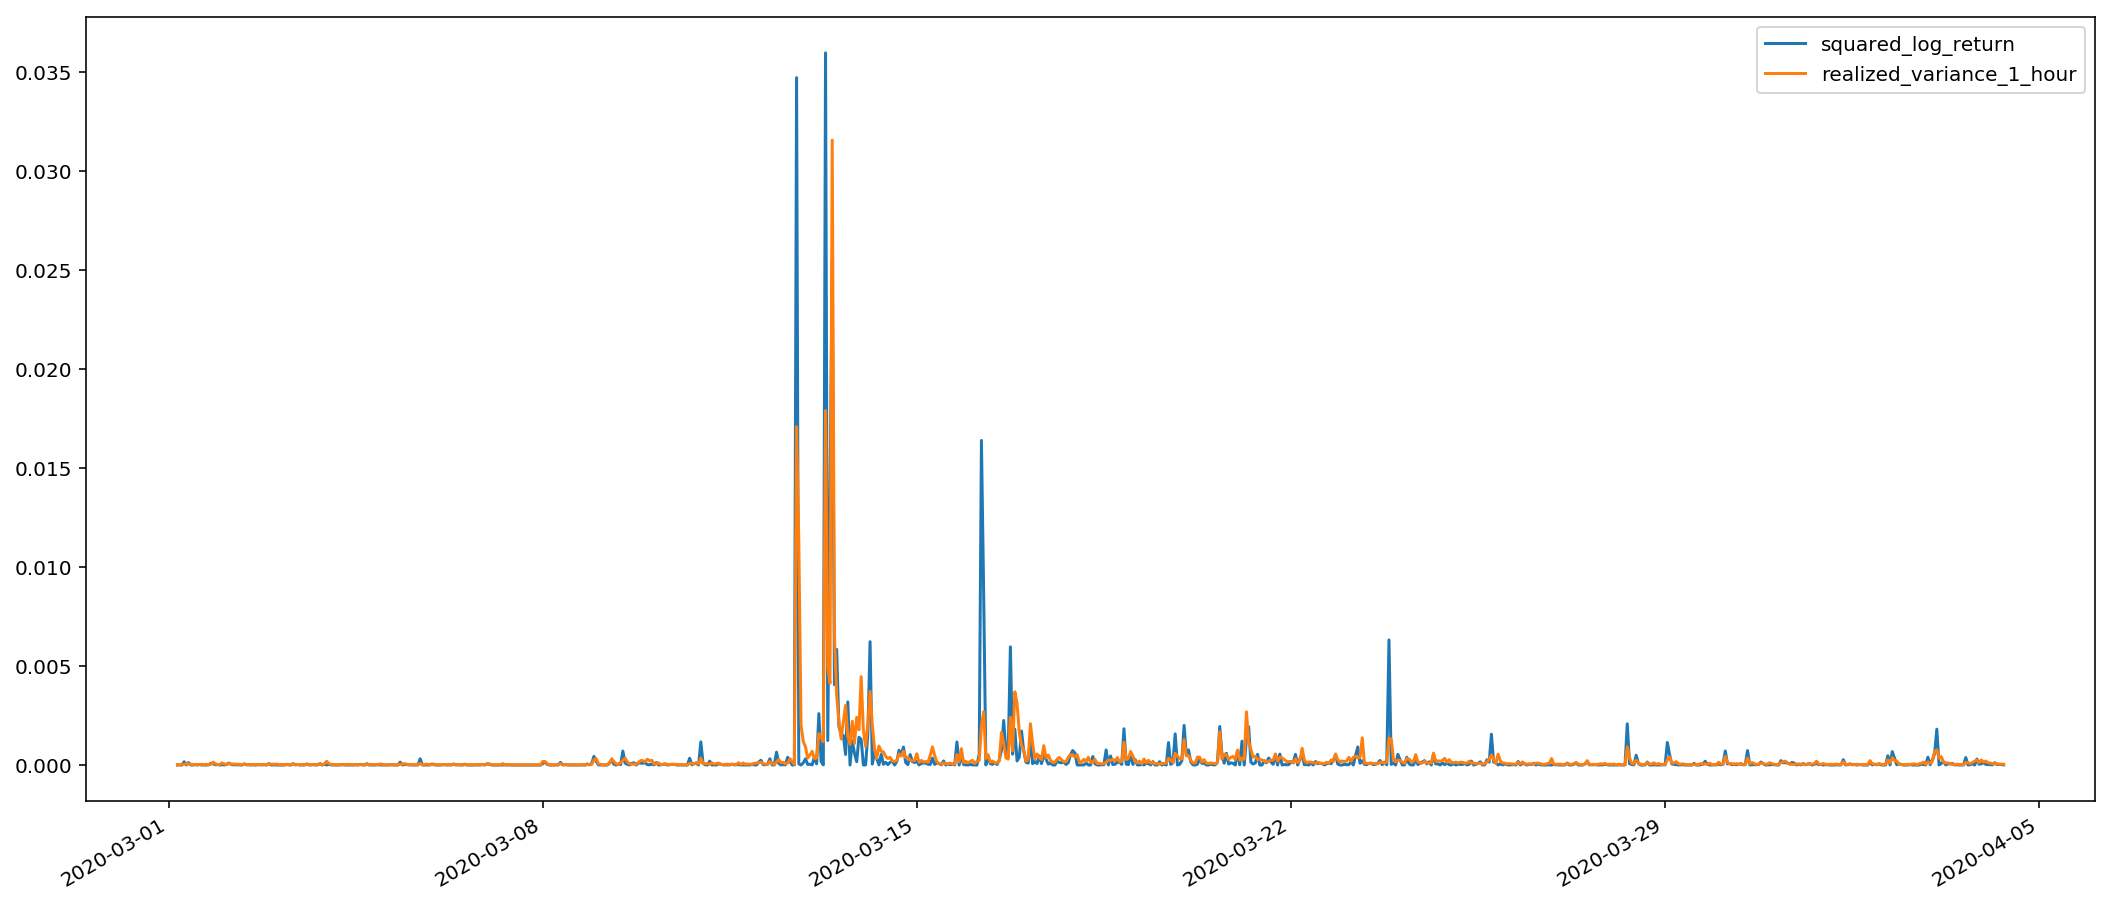

In [30]:
ax1 = kline_test.loc[:, ['squared_log_return', 'realized_variance_1_hour']].plot(figsize = (18,8))
ax1.xaxis.label.set_visible(False)

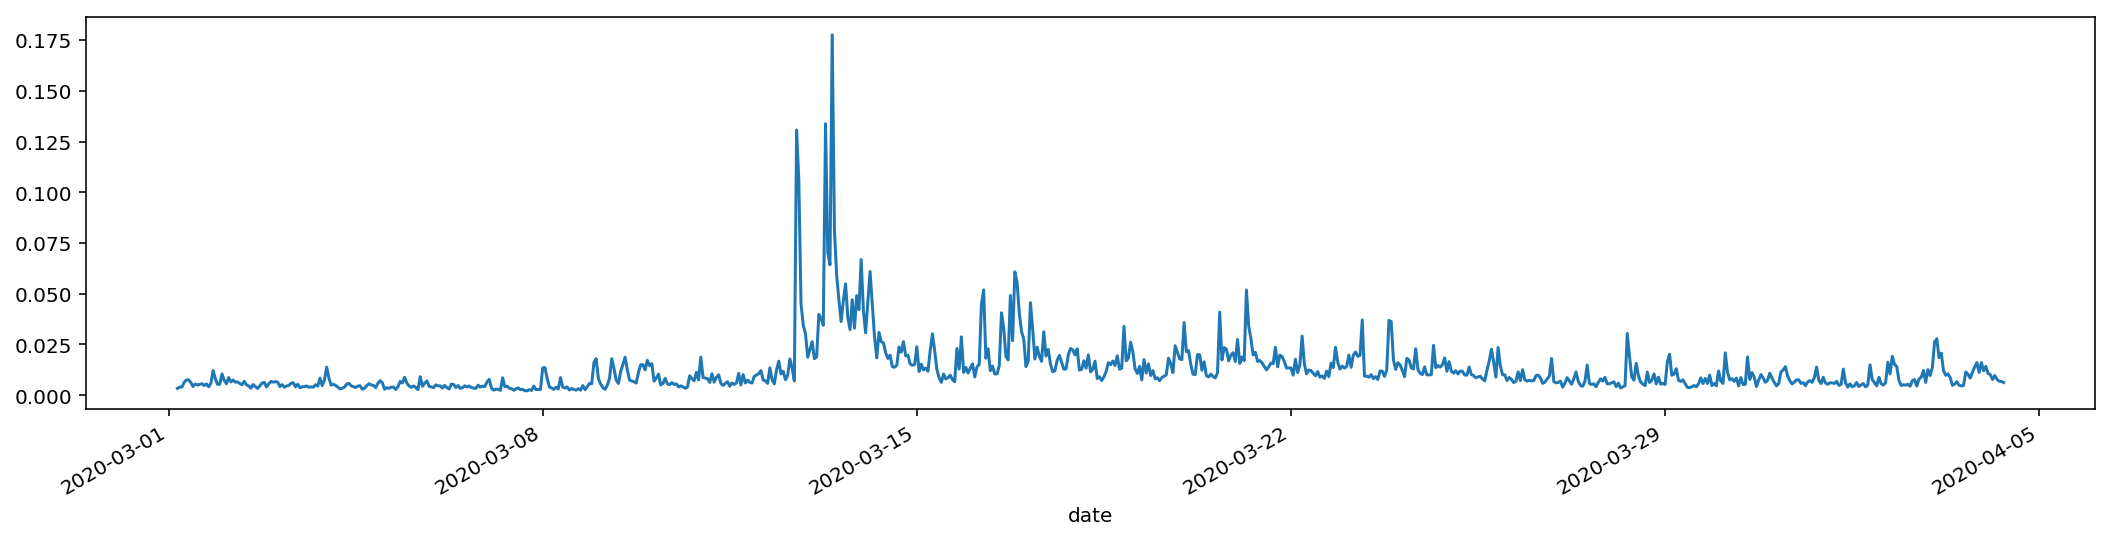

In [205]:
kline_test['realized_volatility_1_hour'].plot(figsize = (18,4))

(<matplotlib.axes._subplots.AxesSubplot at 0x120854a90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x120849198>)

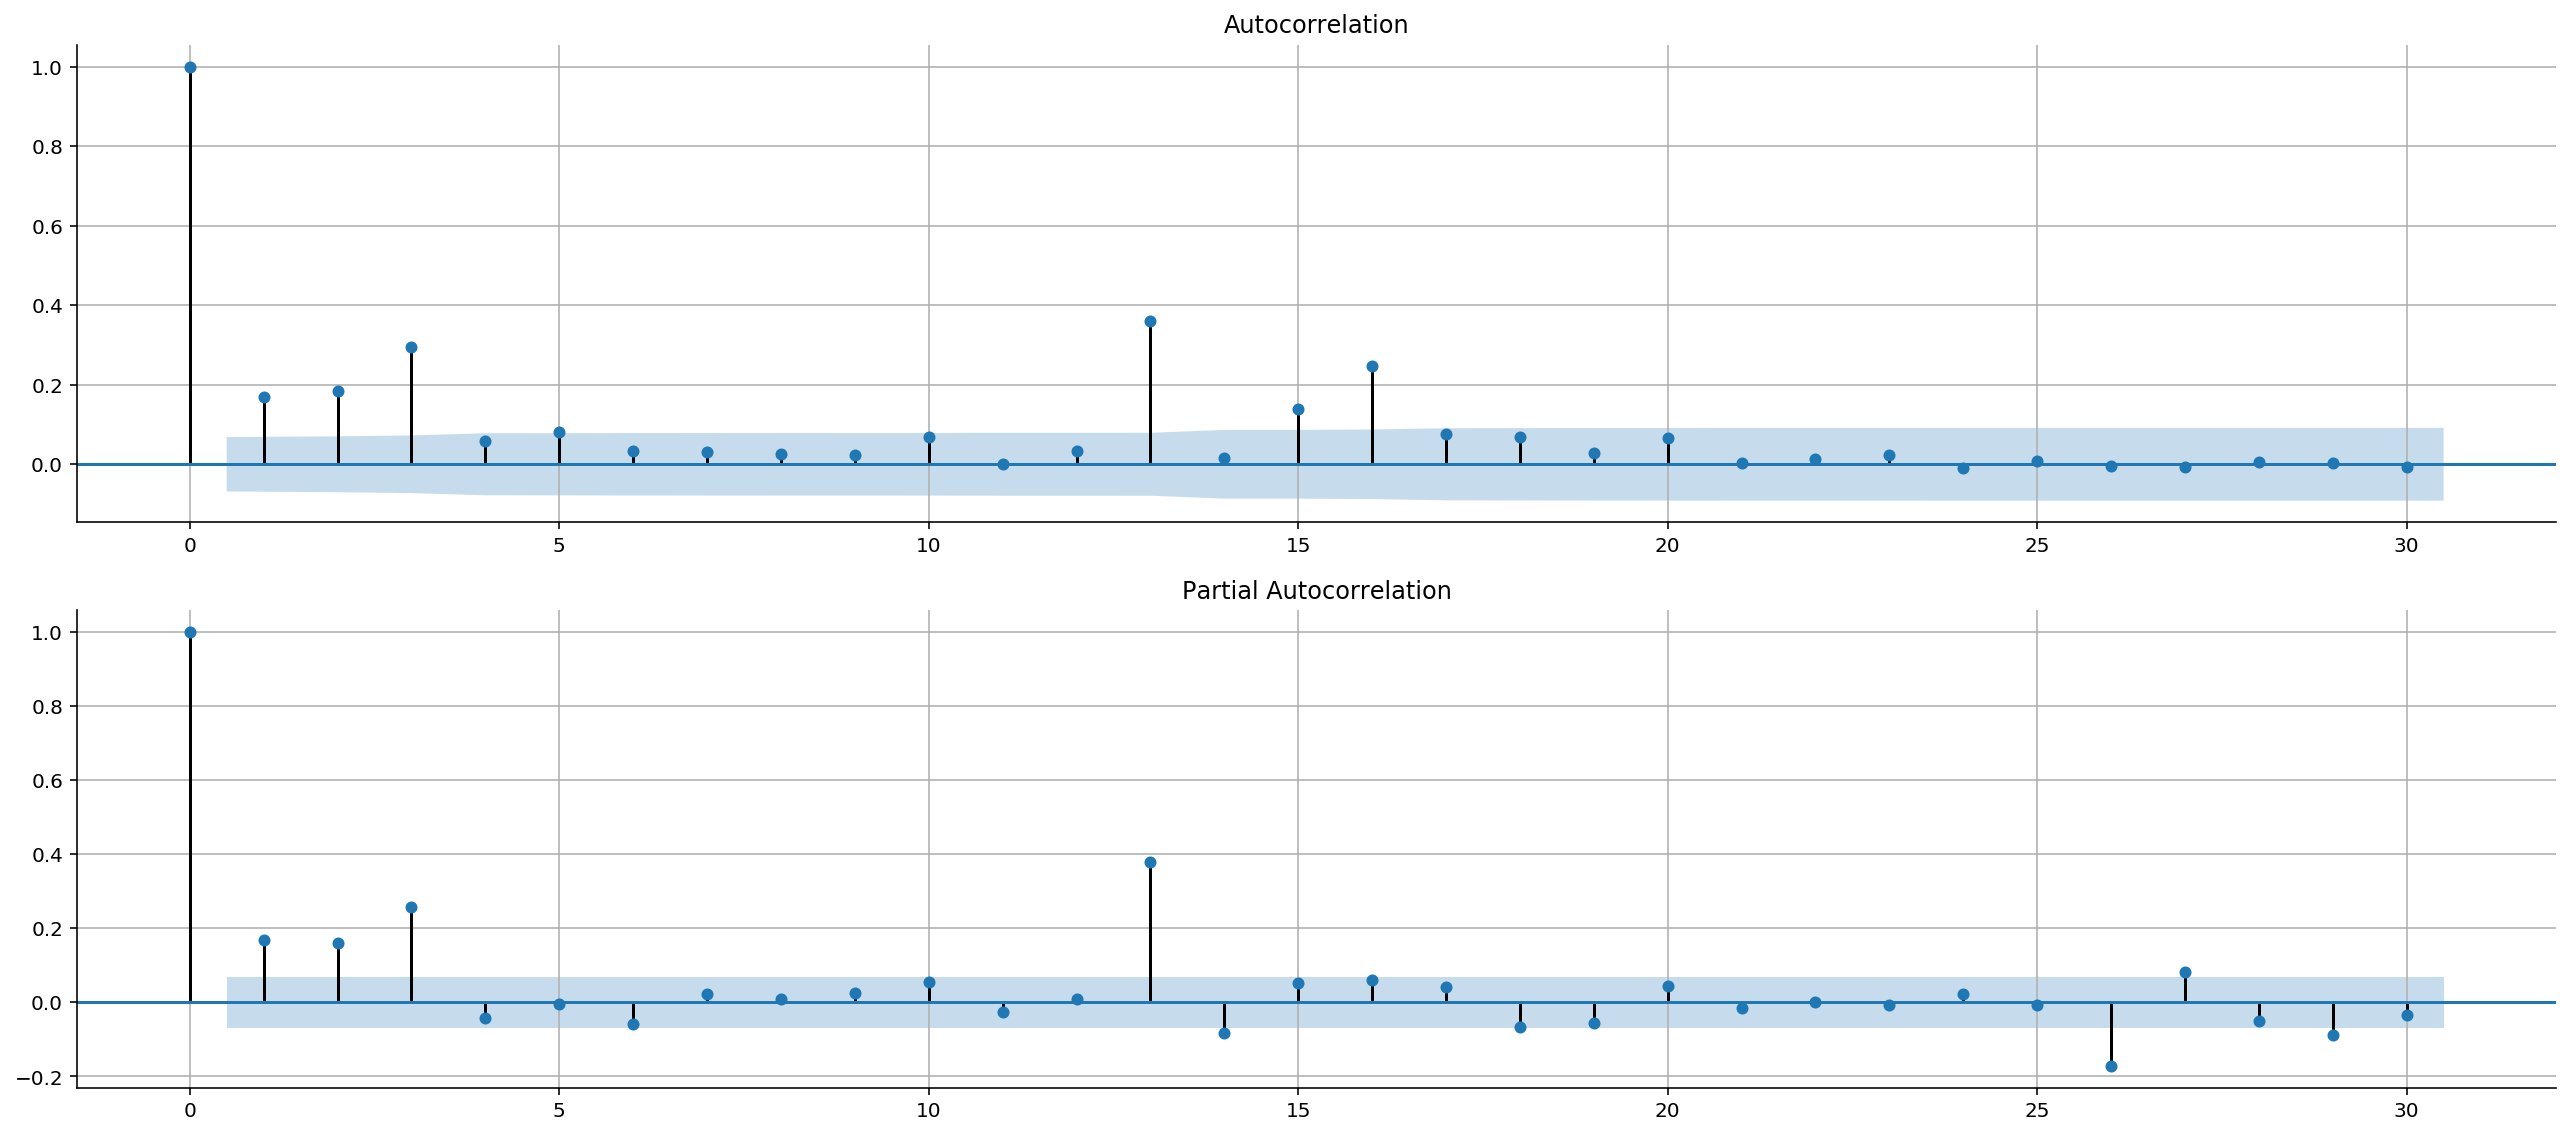

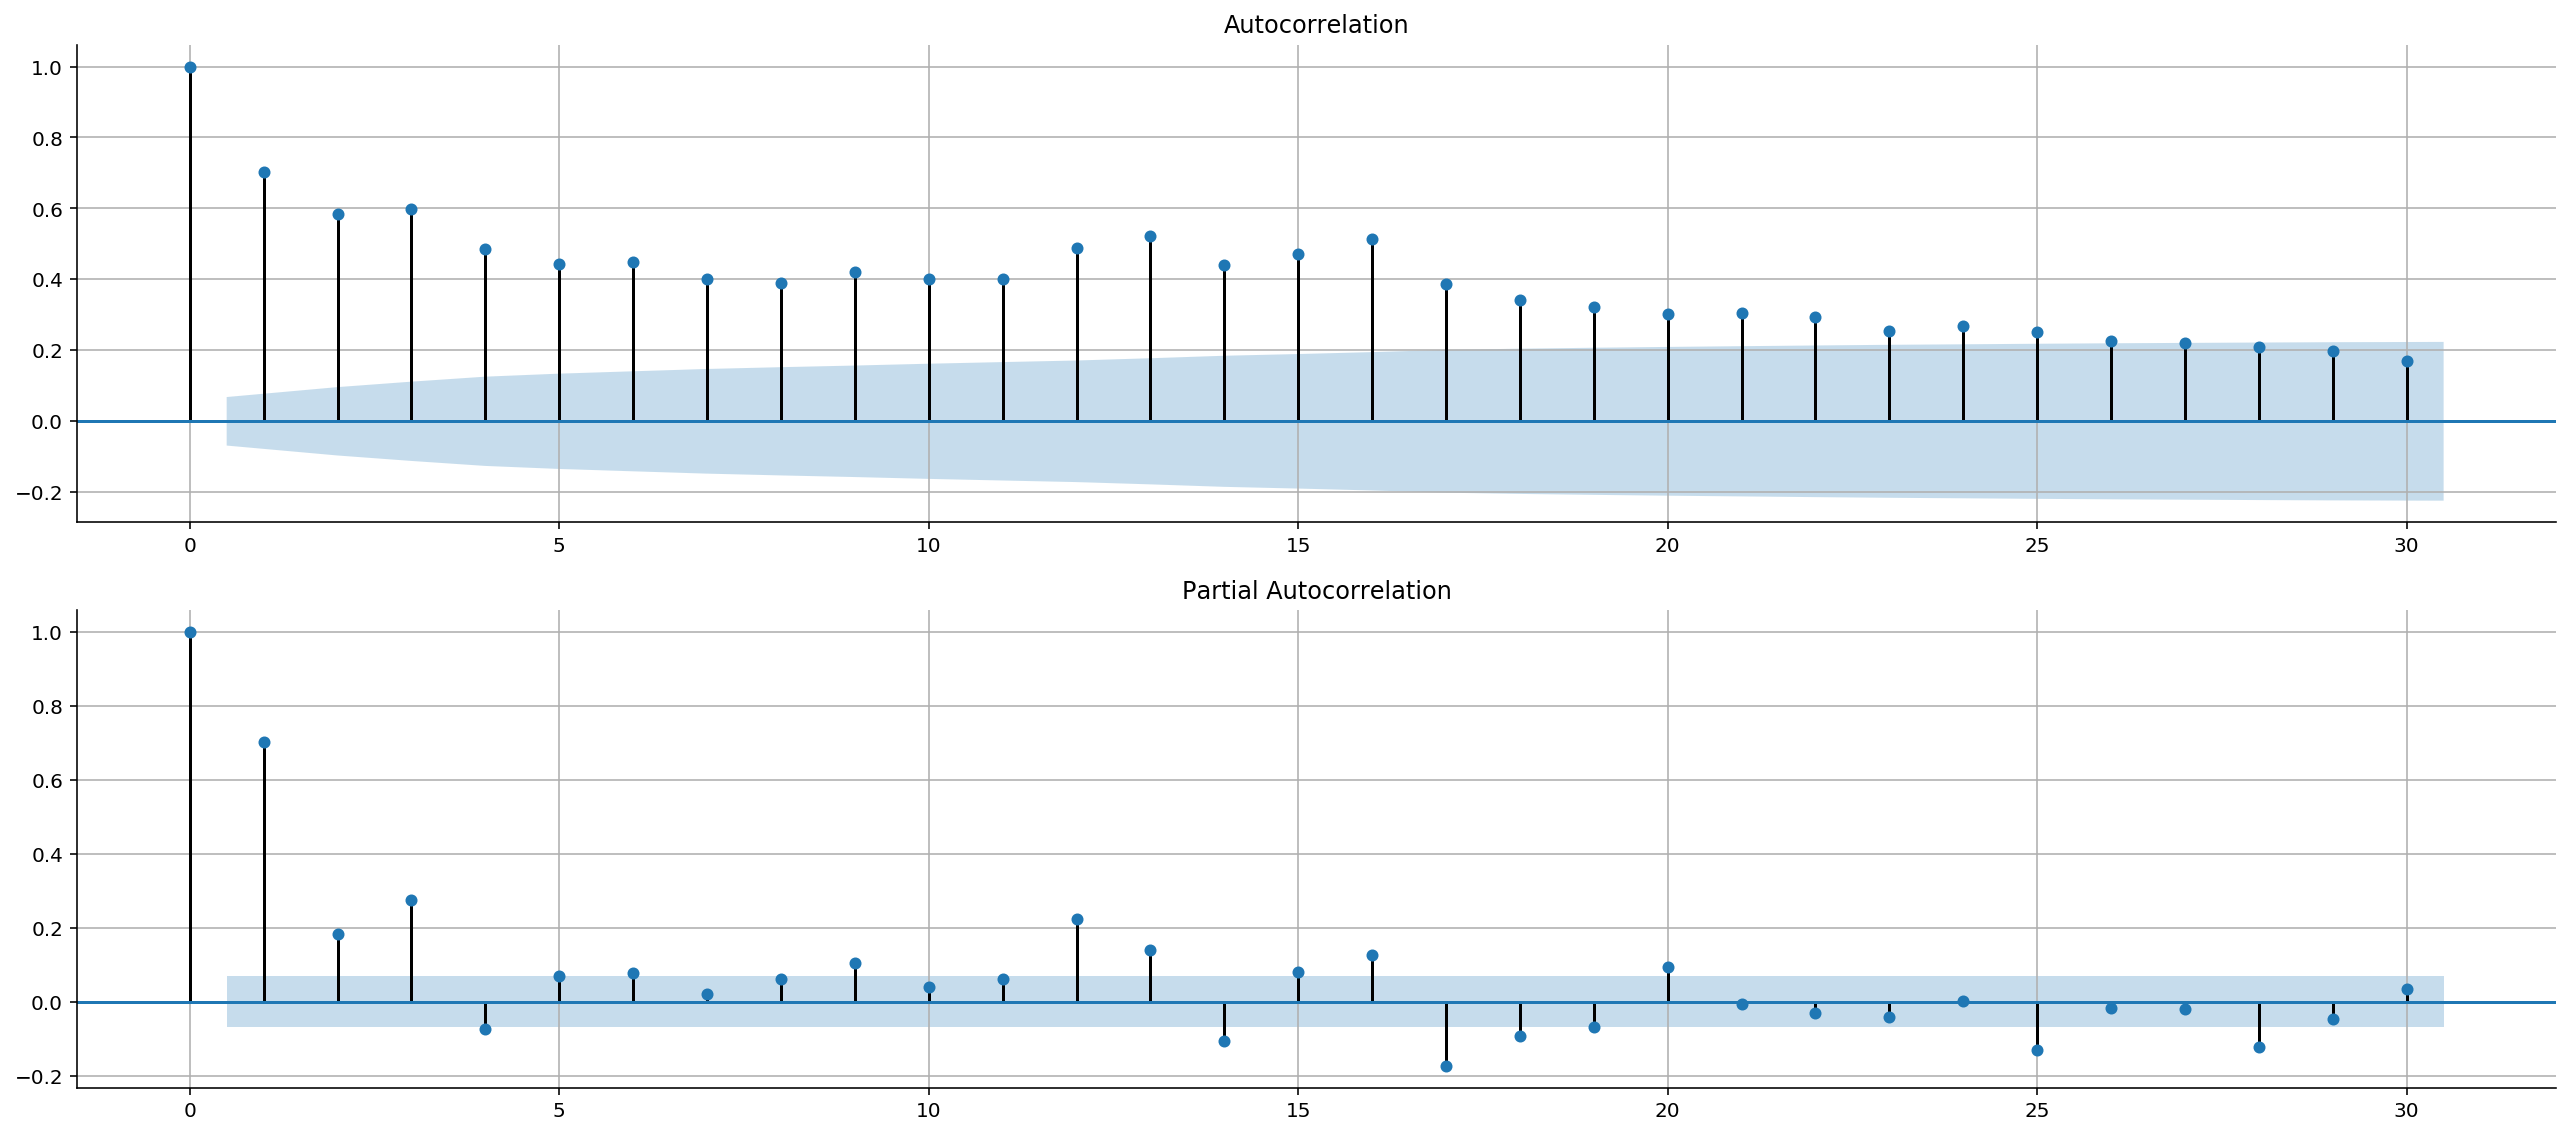

In [31]:
pacfplot(kline_test['squared_log_return'])
pacfplot(kline_test['realized_volatility_1_hour'])

## 第七步 ARCH效应检验

#### 全局变量

In [206]:
cc = 3
model_p = 1
predict_lag = 30
label = 'log_return'  #'log_return_100x'

training_label = label
training_ts = pd.DataFrame(kline_test[training_label], dtype=np.float)

training_arch_label = label
training_arch = pd.DataFrame(kline_test[training_arch_label], dtype=np.float)

training_garch_label = label
training_garch = pd.DataFrame(kline_test[training_garch_label], dtype=np.float)

training_egarch_label = label
training_egarch = pd.DataFrame(kline_test[training_egarch_label], dtype=np.float)

training_arch.head(3)

,log_return
date,
2020-03-01 04:00:00+08:00,-0.002011
2020-03-01 05:00:00+08:00,-0.002562
2020-03-01 06:00:00+08:00,0.000345


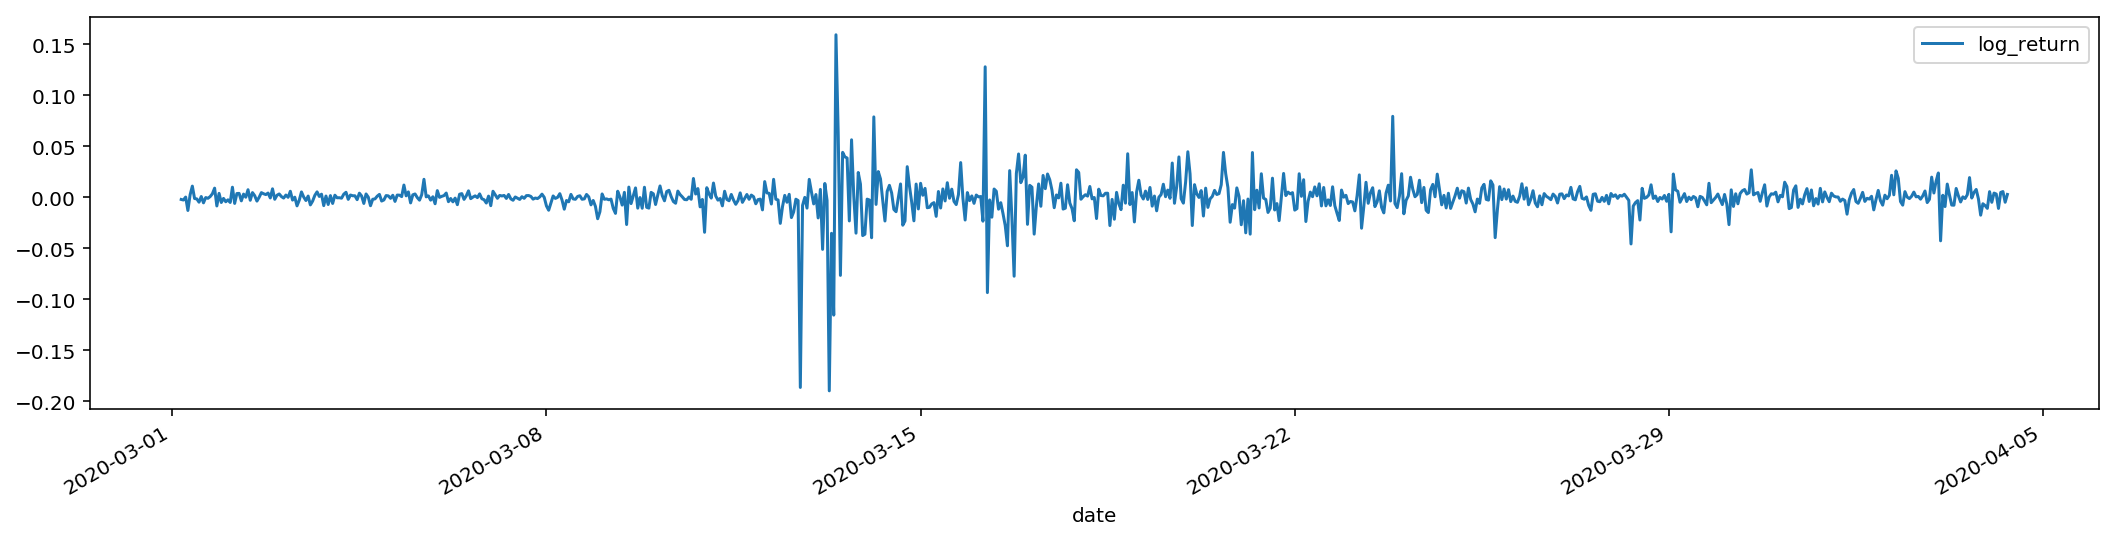

In [33]:
# ARCH 数据集
training_arch.plot(figsize = (18,4))

#### 误差项、正太和方差检验

In [34]:
t = sm.tsa.stattools.adfuller(training_arch[training_arch_label])  # ADF检验
print("p-value:   ",t[1])
#原假设H0：序列为非平稳的，备择假设H1:序列是平稳的
# p-value小于显著性水平，拒绝原假设，因此序列是平稳的，接下来我们建立AR(p)模型，先判定阶次

p-value:    2.8617380012670413e-06


(<matplotlib.axes._subplots.AxesSubplot at 0x120a8ce10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x120bd57b8>)

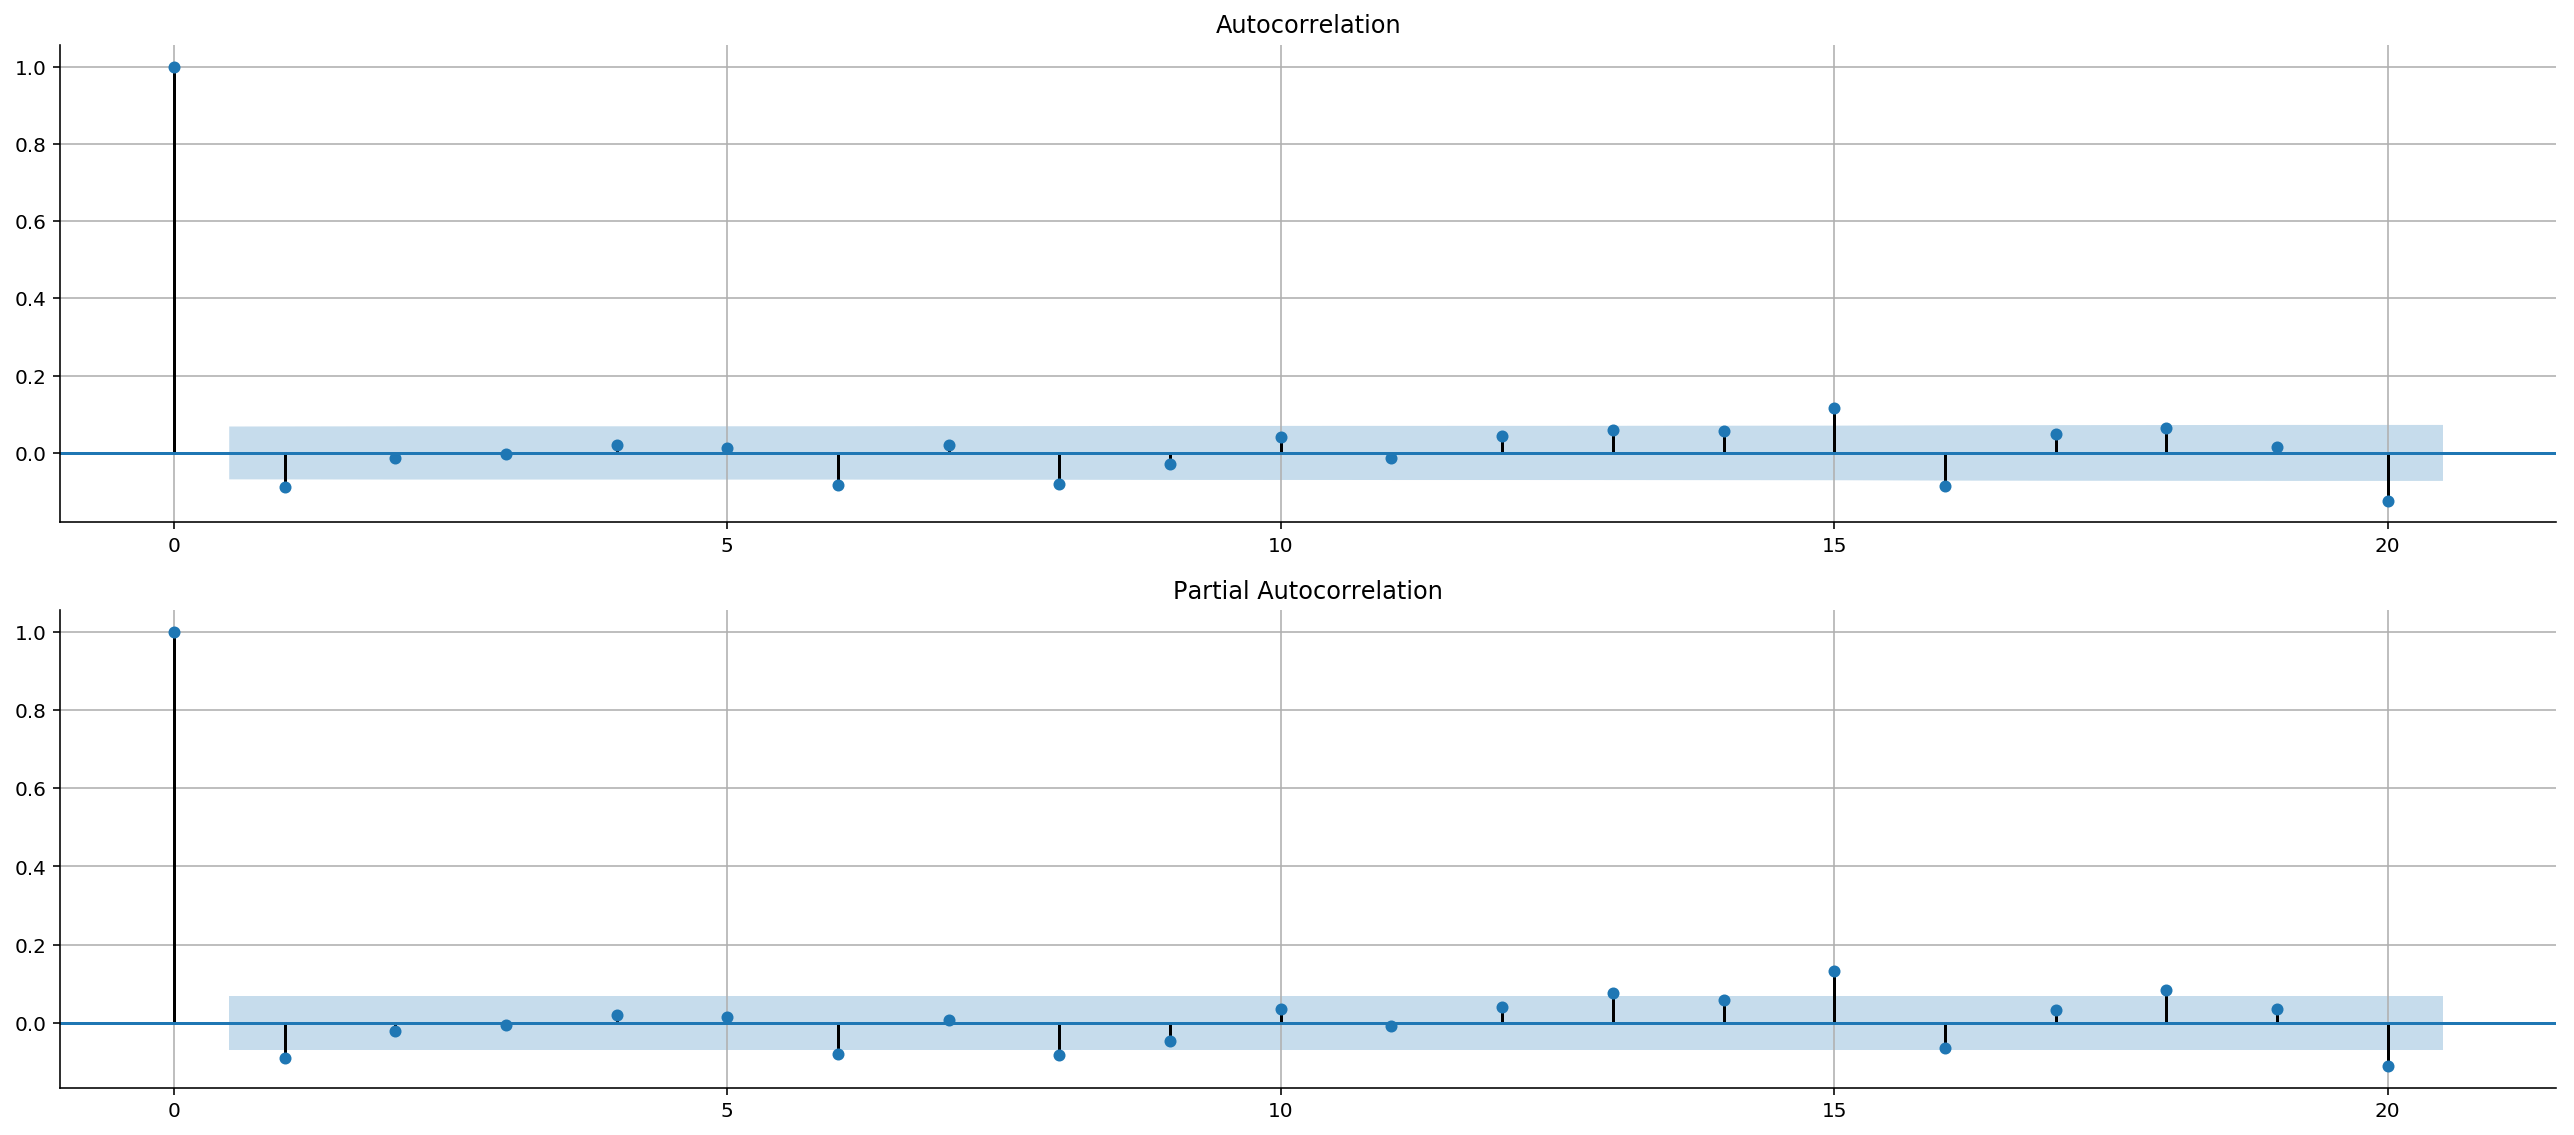

In [35]:
# p<0.05, 认为序列是平稳的，建立AR(p)模型，并判断阶数 
# PACF- AR(p) ACF- MA(q)
pacfplot(training_arch,lags=20)

#### 建立ARIMA均值模型

In [135]:
training_arma_model = smt.SARIMAX(endog=training_ts, trend='c', order=(0, 0, 1), 
                             seasonal_order=(0, 0, 0, 0)#, 
#                              simple_differencing=False,
#                              enforce_stationarity=False,
#                              enforce_invertibility=False
                            )
arma_model_results = training_arma_model.fit(disp=False)
arma_model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             log_return   No. Observations:                  821
Model:               SARIMAX(0, 0, 1)   Log Likelihood                2125.191
Date:                Wed, 15 Apr 2020   AIC                          -4244.382
Time:                        15:08:18   BIC                          -4230.250
Sample:                    03-01-2020   HQIC                         -4238.960
                         - 04-04-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0003      0.001     -0.492      0.623      -0.002       0.001
ma.L1         -0.0906      0.012     -7.599      0.000      -0.114      -0.067
sigma2         0.0003   3.91e-06     84.563      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       77.50   Jarque-Bera (JB):             52635.63
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.33   Skew:                            -1.94
Prob(H) (two-sided):                  0.00   Kurtosis:                        42.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [136]:
training_arma_fitvalue = pd.DataFrame(arma_model_results.fittedvalues,dtype=np.float)  # ARCH效应检验 并作出残差和残差平方图像：
at = pd.merge(training_ts, training_arma_fitvalue, on='date')
at.columns = ['log_return', 'model_fit']
at['res'] = at['log_return'] - at['model_fit']
at['res2'] = np.square(at['res'])
at.head()

,log_return,model_fit,res,res2
date,,,,
2020-03-01 04:00:00+08:00,-0.002011,-0.000309,-0.001702,2.895358e-06
2020-03-01 05:00:00+08:00,-0.002562,-0.000156,-0.002405,5.785010e-06
2020-03-01 06:00:00+08:00,0.000345,-0.000091,0.000437,1.906298e-07
2020-03-01 07:00:00+08:00,-0.012808,-0.000349,-0.012459,1.552300e-04
2020-03-01 08:00:00+08:00,0.002584,0.000820,0.001765,3.114704e-06


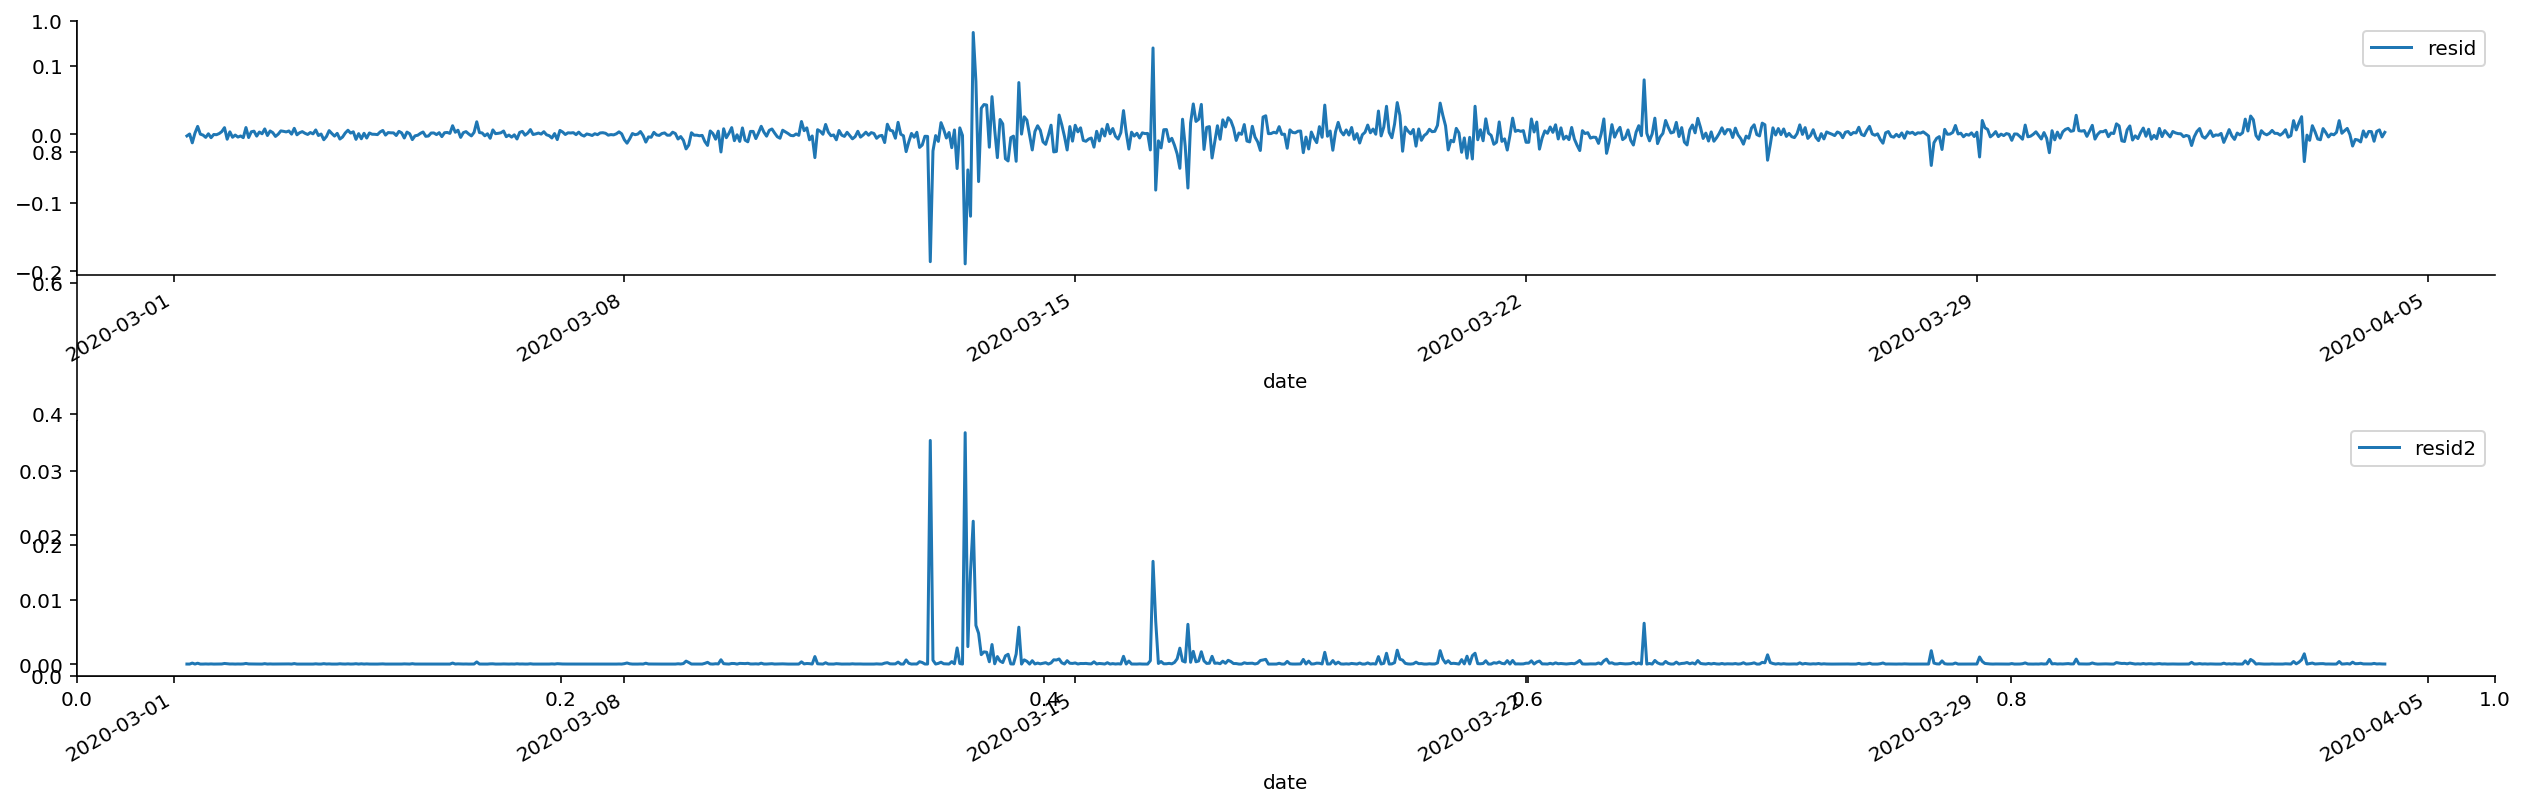

In [137]:
fig, ax = plt.subplots(figsize=(18, 6))
ax1 = fig.add_subplot(2,1,1)
at['res'][1:].plot(ax=ax1,label='resid')
plt.legend(loc='best')

ax2 = fig.add_subplot(2,1,2)
at['res2'][1:].plot(ax=ax2,label='resid2')

plt.legend(loc='best')
plt.tight_layout()
sns.despine()

In [138]:
# 对{a2t}序列进行混成检验： 原假设H0:序列没有相关性，备择假设H1:序列具有相关性
acf,q,p = sm.tsa.acf(at['res2'],nlags=20,qstat=True)  ## 计算自相关系数及p-value
out = np.c_[range(1,21), acf[1:], q, p]
output=pd.DataFrame(out, columns=['lag', "AC", "Q", "P-value"])
output = output.set_index('lag')
output  # p<0.05，认为残差序列具有相关性，符合异方差的假设，因此具有ARCH效应。

,AC,Q,P-value
lag,,,
1.0,0.194812,31.272363,2.242493e-08
2.0,0.206484,66.447237,3.725339e-15
3.0,0.273372,128.177647,1.335898e-27
4.0,0.081947,133.731349,6.198072e-28
5.0,0.075343,138.431783,3.854518e-28
6.0,0.030534,139.204715,1.474945e-27
7.0,0.032086,140.059299,4.939634e-27
8.0,0.031708,140.894867,1.545733e-26
9.0,0.020787,141.254424,5.681931e-26


#### ARCH模型定阶

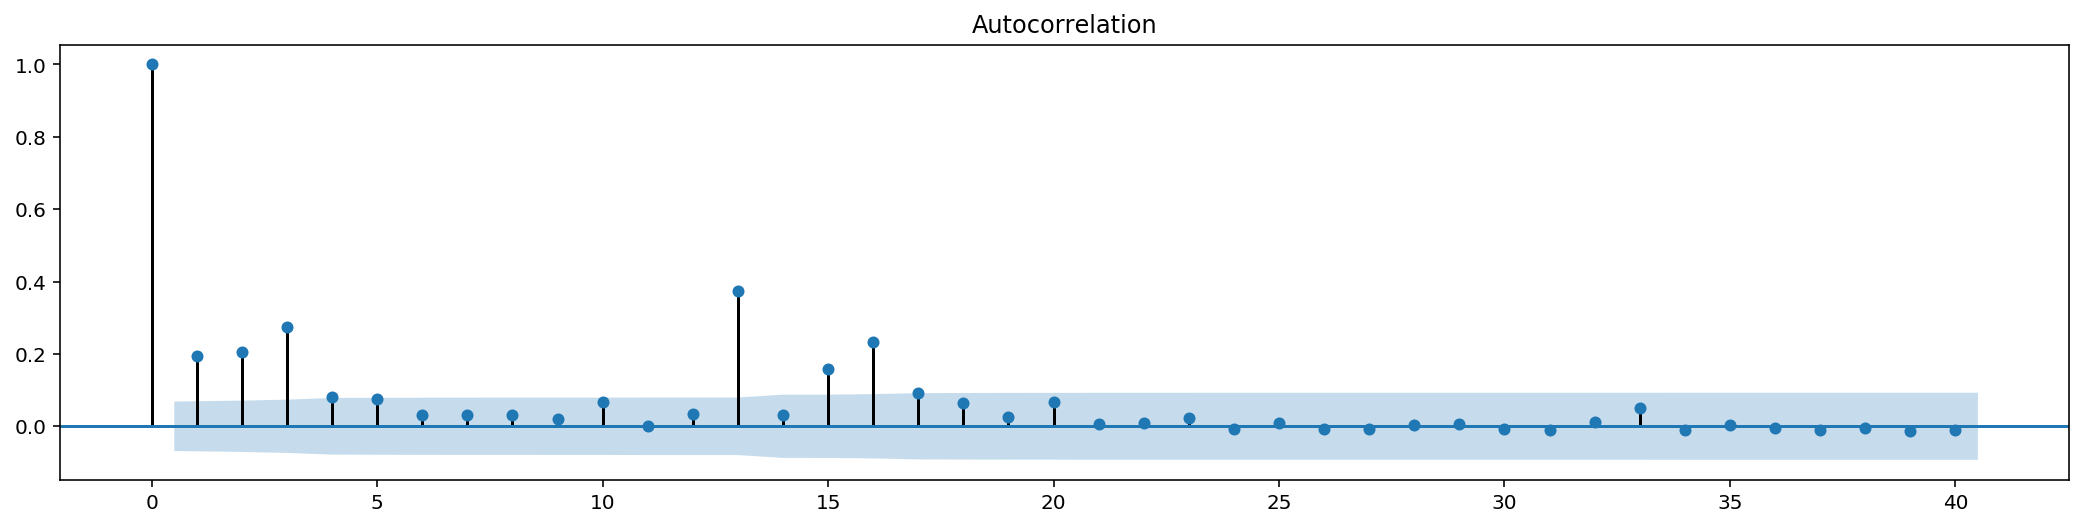

In [310]:
# 用$\{ a^2_t \}$序列偏自相关函数（pACF）确定：
figure = plt.figure(figsize=(18,4))
ax1 = figure.add_subplot(111)
fig = sm.graphics.tsa.plot_acf(at['res2'],lags = 40, ax=ax1) # P = 3

## 建立ARCH模型

In [222]:
trained_ARCH = arch_model(training_arch, mean='AR', vol='ARCH', 
                          lags=model_lags, p=1, dist='ged')
res_ARCH = trained_ARCH.fit(disp=False, options={'ftol': 1e-01})
res_ARCH.summary()  # 得到模型

Iteration:      1,   Func. Count:      9,   Neg. LLF: -2370.4390143614473


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 AR - ARCH Model Results                                  
==========================================================================================
Dep. Variable:                         log_return   R-squared:                       0.007
Mean Model:                                    AR   Adj. R-squared:                  0.003
Vol Model:                                   ARCH   Log-Likelihood:                2370.80
Distribution:      Generalized Error Distribution   AIC:                          -4727.60
Method:                        Maximum Likelihood   BIC:                          -4694.66
                                                    No. Observations:                  818
Date:                            Sat, Apr 18 2020   Df Residuals:                      811
Time:                                    09:21:31   Df Model:                            7
                                    Mean Model                                   
=================================================================================
                     coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------------------------
Const          4.3795e-04  4.562e-04      0.960      0.337 [-4.561e-04,1.332e-03]
log_return[1]     -0.0906  4.651e-02     -1.948  5.141e-02    [ -0.182,5.551e-04]
log_return[2]     -0.0220  7.536e-02     -0.292      0.771      [ -0.170,  0.126]
log_return[3] -4.7074e-03  7.936e-02 -5.932e-02      0.953      [ -0.160,  0.151]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      2.1555e-04  3.681e-04      0.586      0.558 [-5.059e-04,9.370e-04]
alpha[1]       0.3500      0.357      0.980      0.327      [ -0.350,  1.050]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             1.5000      1.397      1.074      0.283 [ -1.237,  4.237]
========================================================================

Covariance estimator: robust
"""

In [223]:
res_ARCH.params

Const            0.000438
log_return[1]   -0.090610
log_return[2]   -0.021974
log_return[3]   -0.004707
omega            0.000216
alpha[1]         0.350000
nu               1.500000
Name: params, dtype: float64

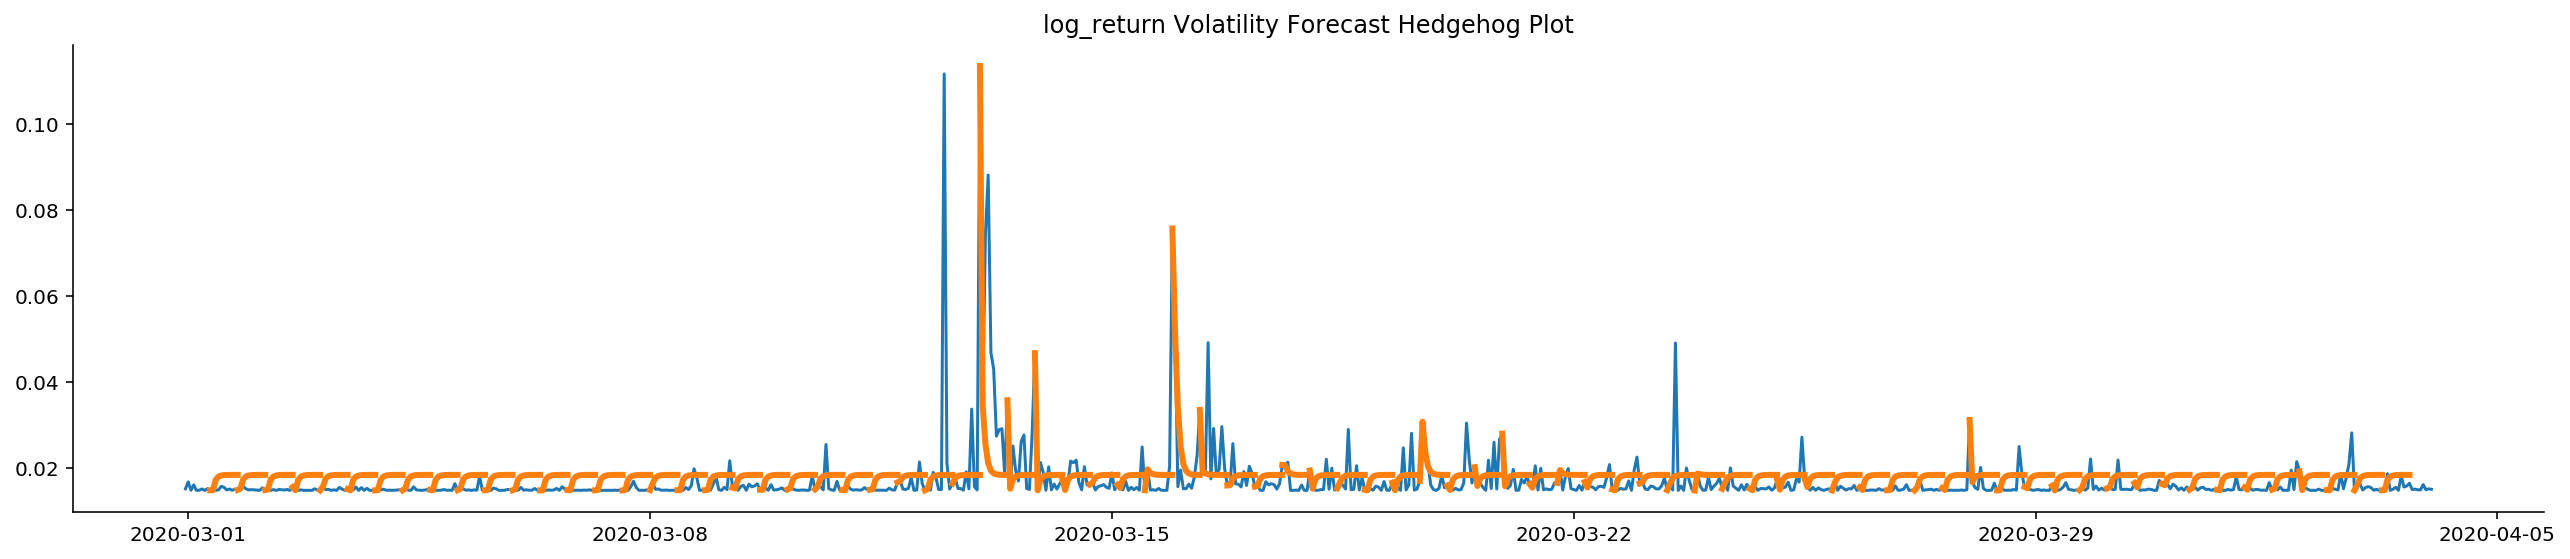

In [224]:
fig = res_ARCH.hedgehog_plot(plot_type='volatility')
fig.set_size_inches(18, 4)
plt.tight_layout()
sns.despine()

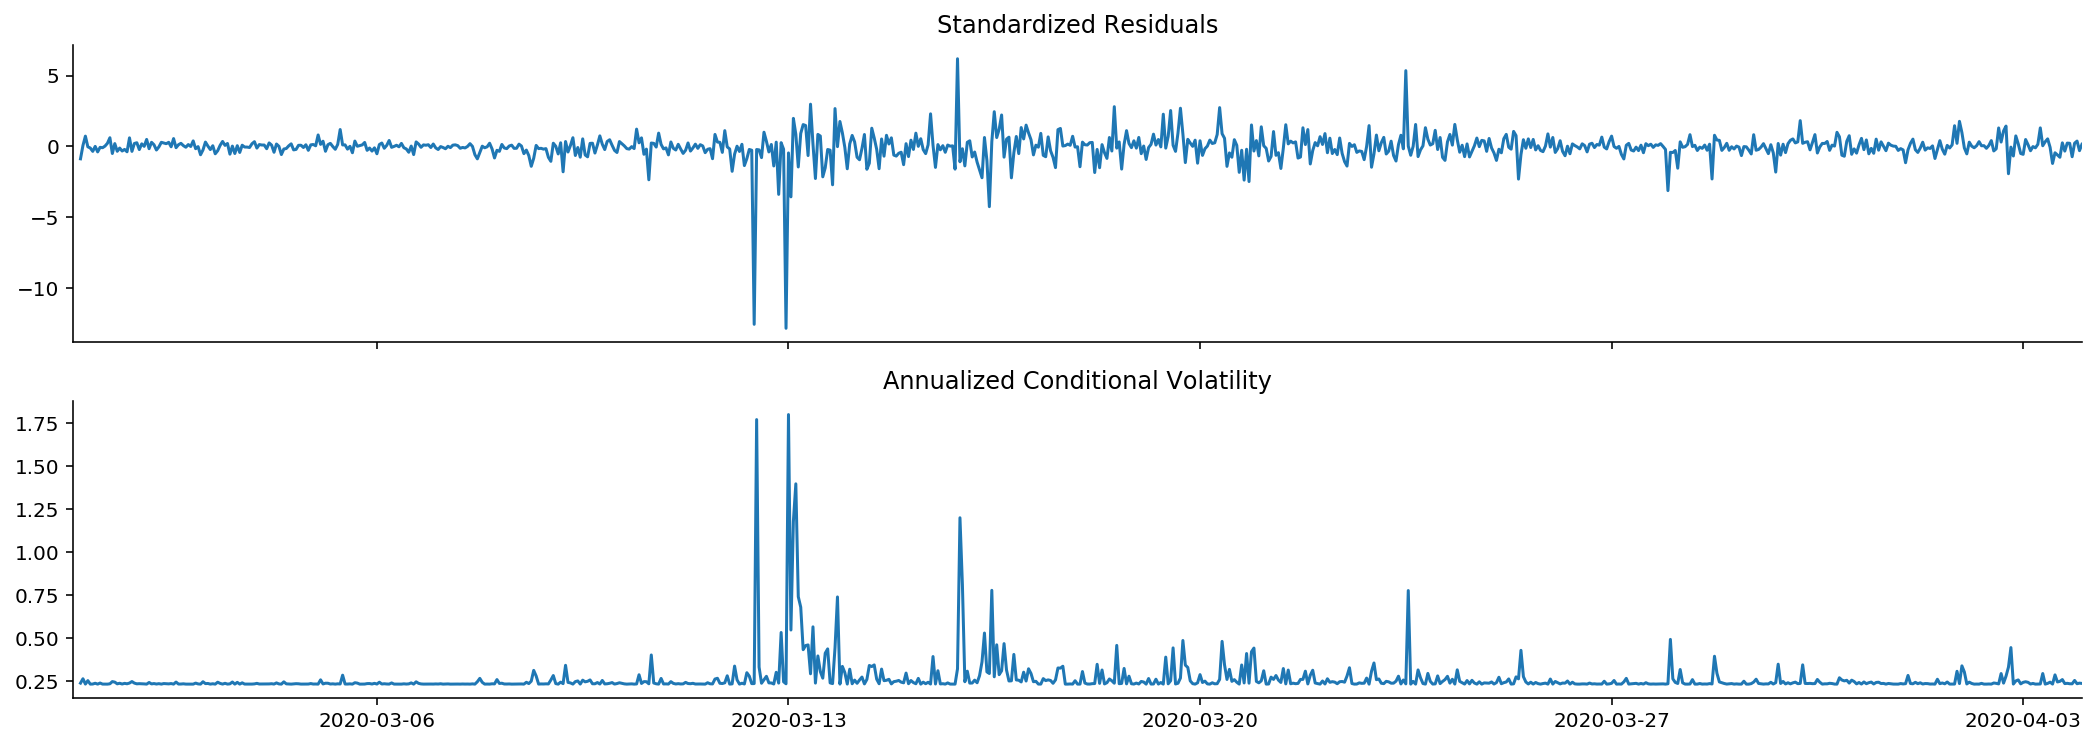

In [225]:
fig = res_ARCH.plot(annualize='D')# standardized residual
fig.set_size_inches(18, 6)# conditional volatility
sns.despine()

#### ARCH预测

ARCH模型
            $$a_t = \sigma_t \epsilon_t \\
              \sigma^2_t = \alpha_0 + \alpha_1 a^2_{t-1} + \cdots + \alpha_m a^2_{t-m}$$
其中，$\{ \epsilon_t \}$是均值为0，方差为1的独立同分布随机变量序列，$\alpha_0 >0, \alpha_1, \cdots, \alpha_m \geq 0$.

Mean Absolute Error (MAE): 0.0124
Mean Absolute Percentage Error (MAPE): 97.8
Root Mean Square Error (RMSE): 0.0182


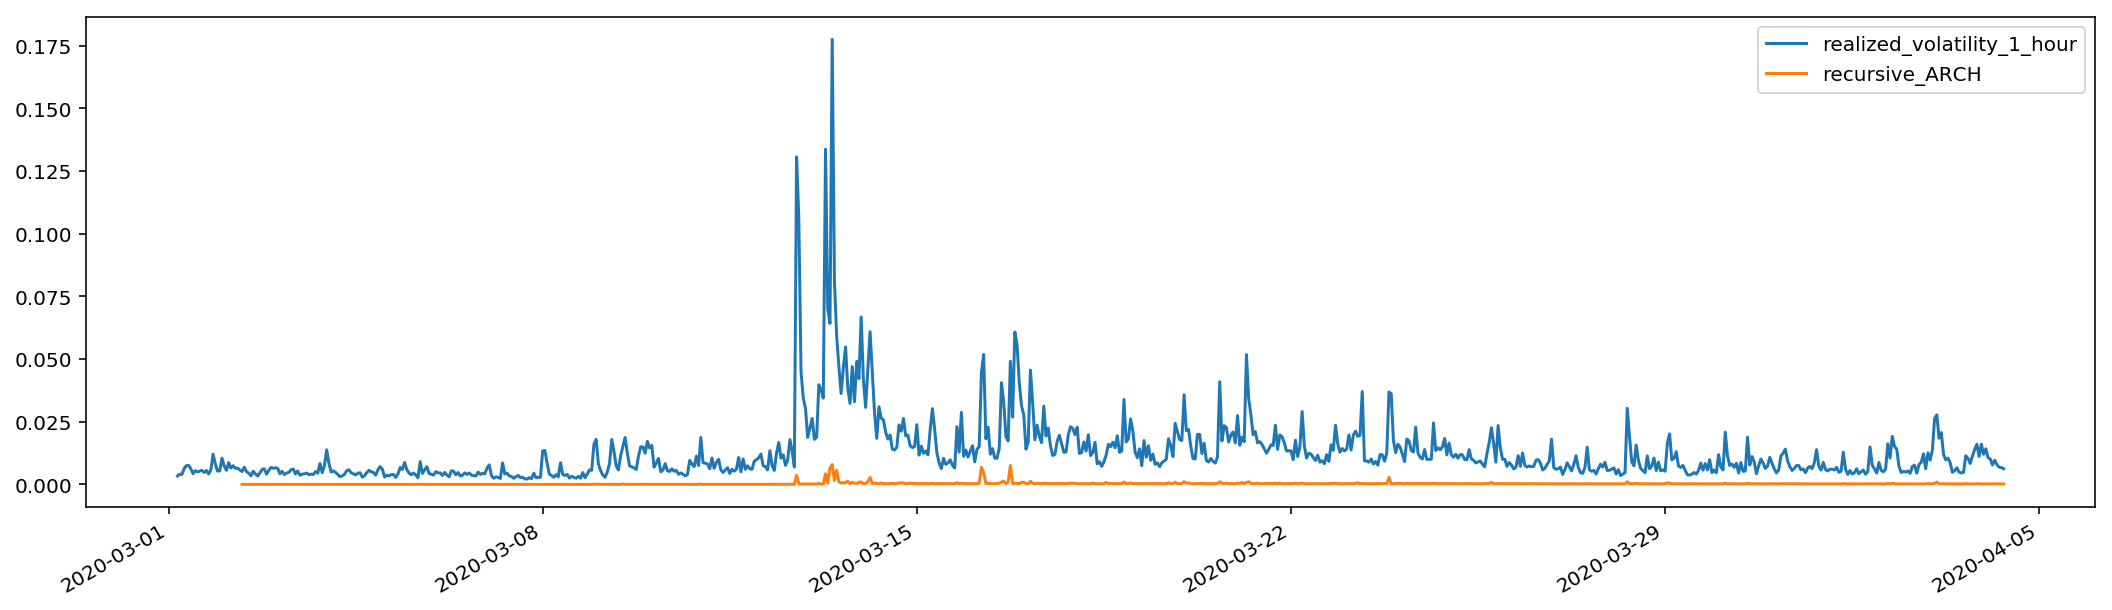

In [226]:
def recursive_forecast(pd_dataframe):     
    window = predict_lag
    model = 'ARCH'
    index = kline_test[1:].index
    end_loc = np.where(index >= kline_test.index[window])[0].min()
    forecasts = {}
    for i in range(len(kline_test[1:]) - window + 2):
        mod = arch_model(pd_dataframe['log_return'][1:], mean='AR', vol=model, dist='ged', p=1)
        res = mod.fit(last_obs=i+end_loc, disp='off', options={'ftol': 1e03})
        temp = res.forecast().variance
        fcast = temp.iloc[i + end_loc - 1]
        forecasts[fcast.name] = fcast

    forecasts = pd.DataFrame(forecasts).T
    pd_dataframe['recursive_{}'.format(model)] = forecasts['h.1']
    evaluate(pd_dataframe, 'realized_volatility_1_hour', 'recursive_{}'.format(model))

recursive_forecast(kline_test)

## 建立GARCH模型

In [231]:
am_GARCH = arch_model(training_garch, mean='AR', vol='GARCH',
                      p=1, q=1, lags=model_lags, dist='ged')
res_GARCH = am_GARCH.fit(disp=False, options={'ftol': 1e-01})
res_GARCH.summary()

Iteration:      1,   Func. Count:     10,   Neg. LLF: -2502.748233705034


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 AR - GARCH Model Results                                 
==========================================================================================
Dep. Variable:                         log_return   R-squared:                       0.007
Mean Model:                                    AR   Adj. R-squared:                  0.004
Vol Model:                                  GARCH   Log-Likelihood:                2504.46
Distribution:      Generalized Error Distribution   AIC:                          -4992.92
Method:                        Maximum Likelihood   BIC:                          -4955.26
                                                    No. Observations:                  818
Date:                            Sat, Apr 18 2020   Df Residuals:                      810
Time:                                    09:22:57   Df Model:                            8
                                    Mean Model                                   
=================================================================================
                     coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------------------------
Const          2.5822e-04  2.907e-04      0.888      0.374 [-3.115e-04,8.279e-04]
log_return[1]     -0.0906  4.725e-02     -1.918  5.516e-02    [ -0.183,1.999e-03]
log_return[2]     -0.0220  4.184e-02     -0.525      0.600    [ -0.104,6.004e-02]
log_return[3] -4.7084e-03  3.142e-02     -0.150      0.881 [-6.628e-02,5.687e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      6.6326e-06  4.185e-11  1.585e+05      0.000 [6.633e-06,6.633e-06]
alpha[1]       0.1000  6.539e-02      1.529      0.126  [-2.816e-02,  0.228]
beta[1]        0.8800  2.604e-02     33.788 2.939e-250     [  0.829,  0.931]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             1.5000  3.199e-04   4689.487      0.000 [  1.499,  1.501]
========================================================================

Covariance estimator: robust
"""

In [232]:
res_GARCH.params  # 得到模型

Const            0.000258
log_return[1]   -0.090609
log_return[2]   -0.021973
log_return[3]   -0.004708
omega            0.000007
alpha[1]         0.100000
beta[1]          0.880000
nu               1.500000
Name: params, dtype: float64

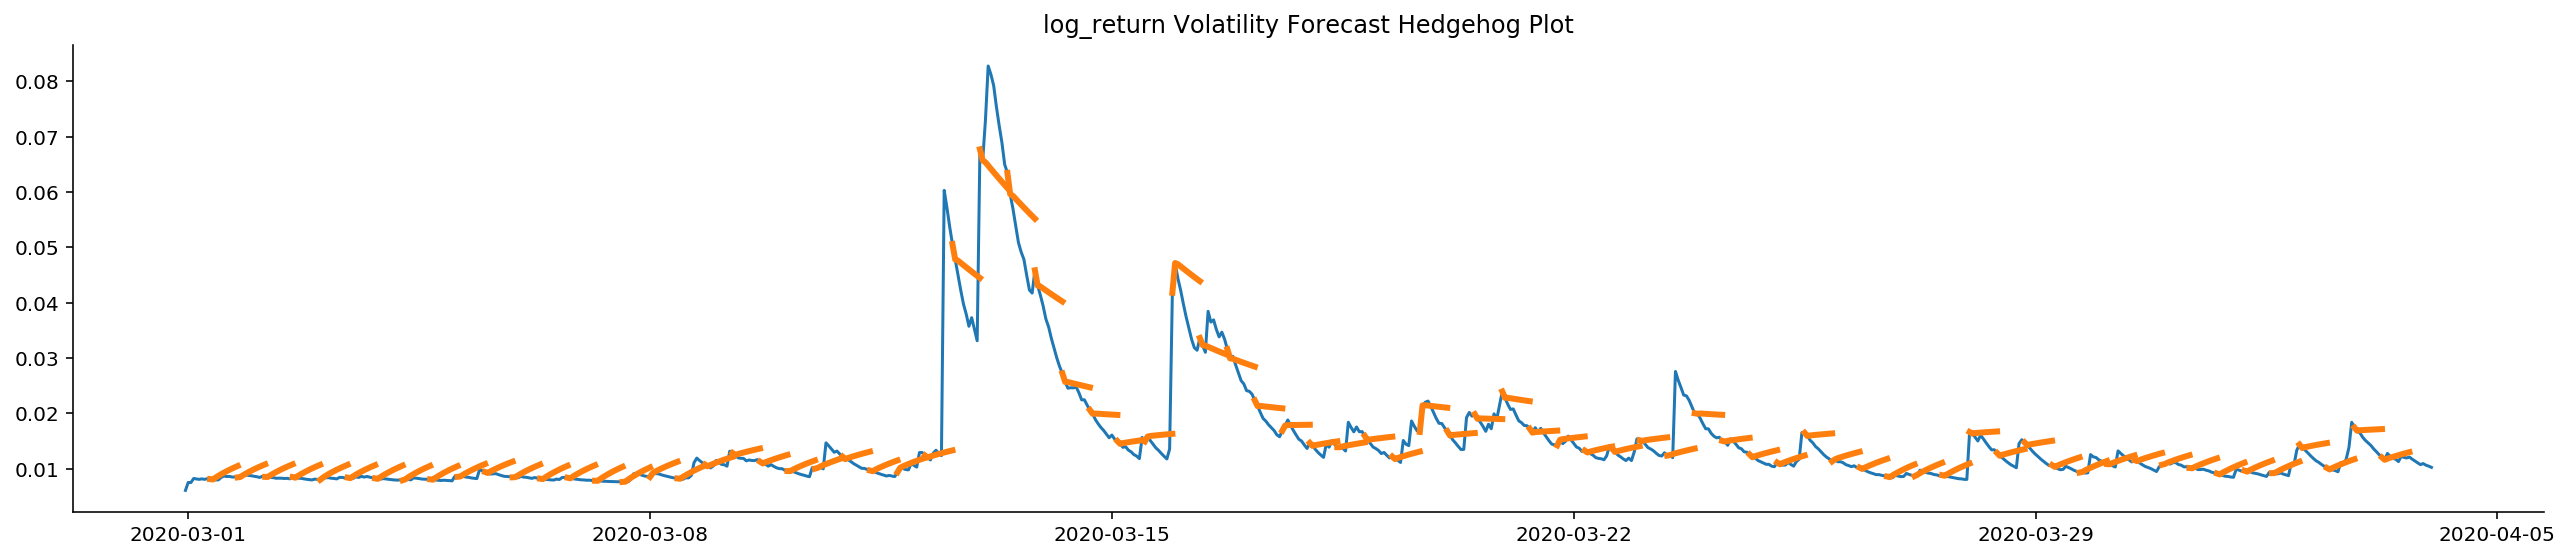

In [233]:
fig = res_GARCH.hedgehog_plot(plot_type='volatility')
fig.set_size_inches(18, 4)
plt.tight_layout()
sns.despine()

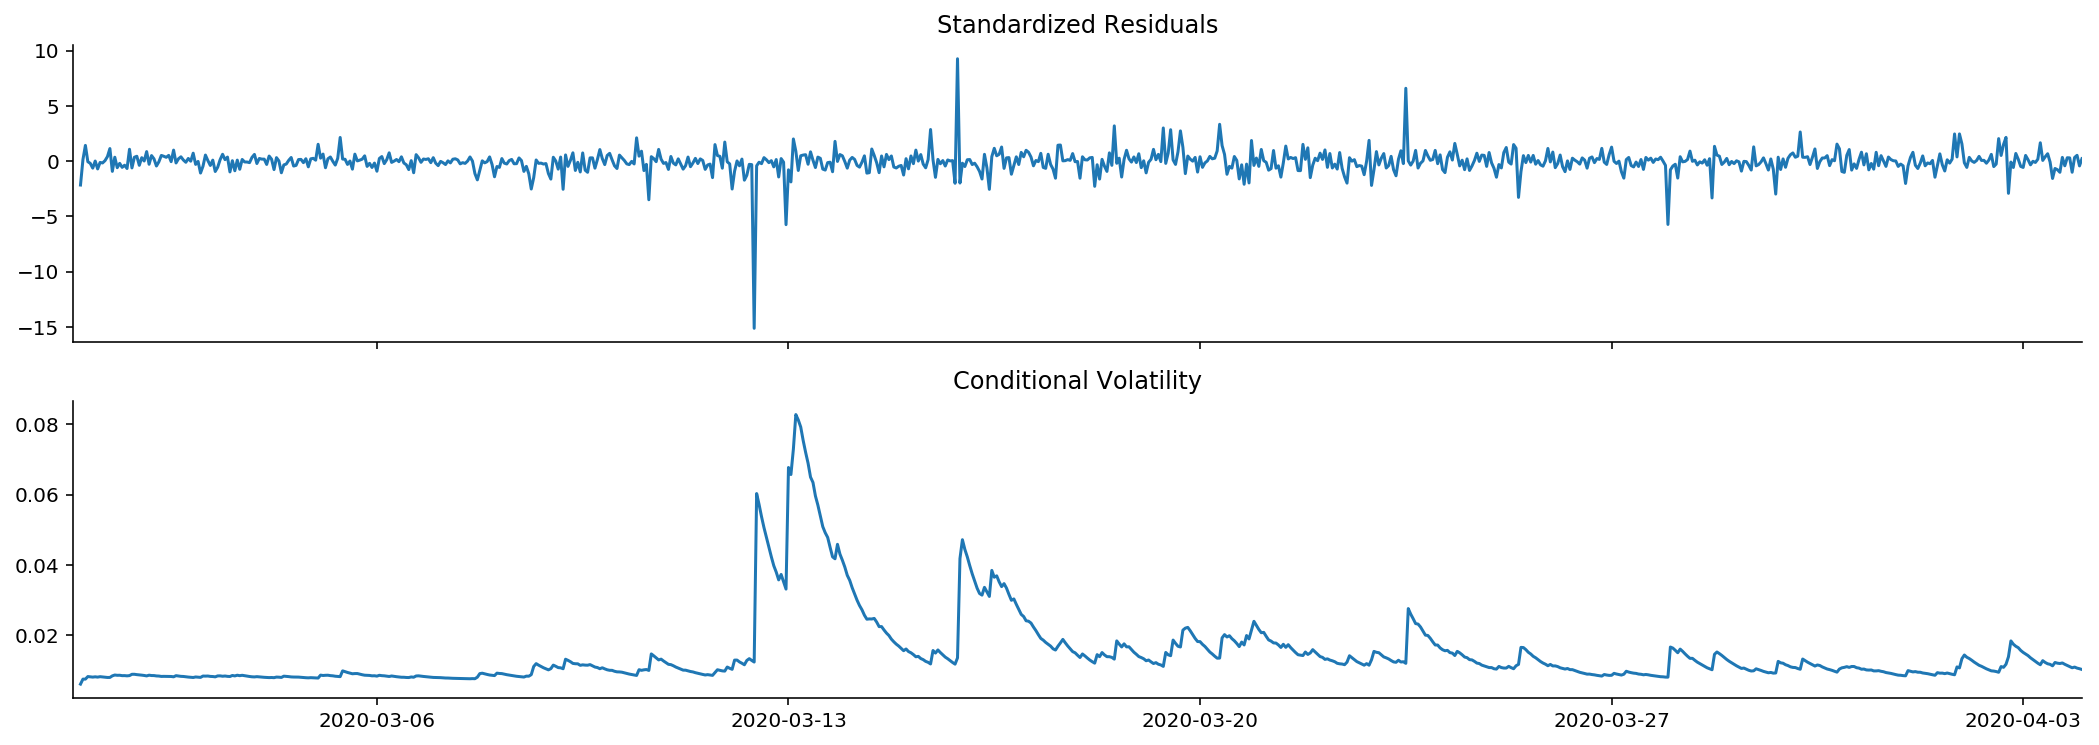

In [234]:
fig = res_GARCH.plot()# standardized residual
fig.set_size_inches(18, 6)# conditional volatility
sns.despine()

#### GARCH预测

Mean Absolute Error (MAE): 0.012
Mean Absolute Percentage Error (MAPE): 96.2
Root Mean Square Error (RMSE): 0.0175


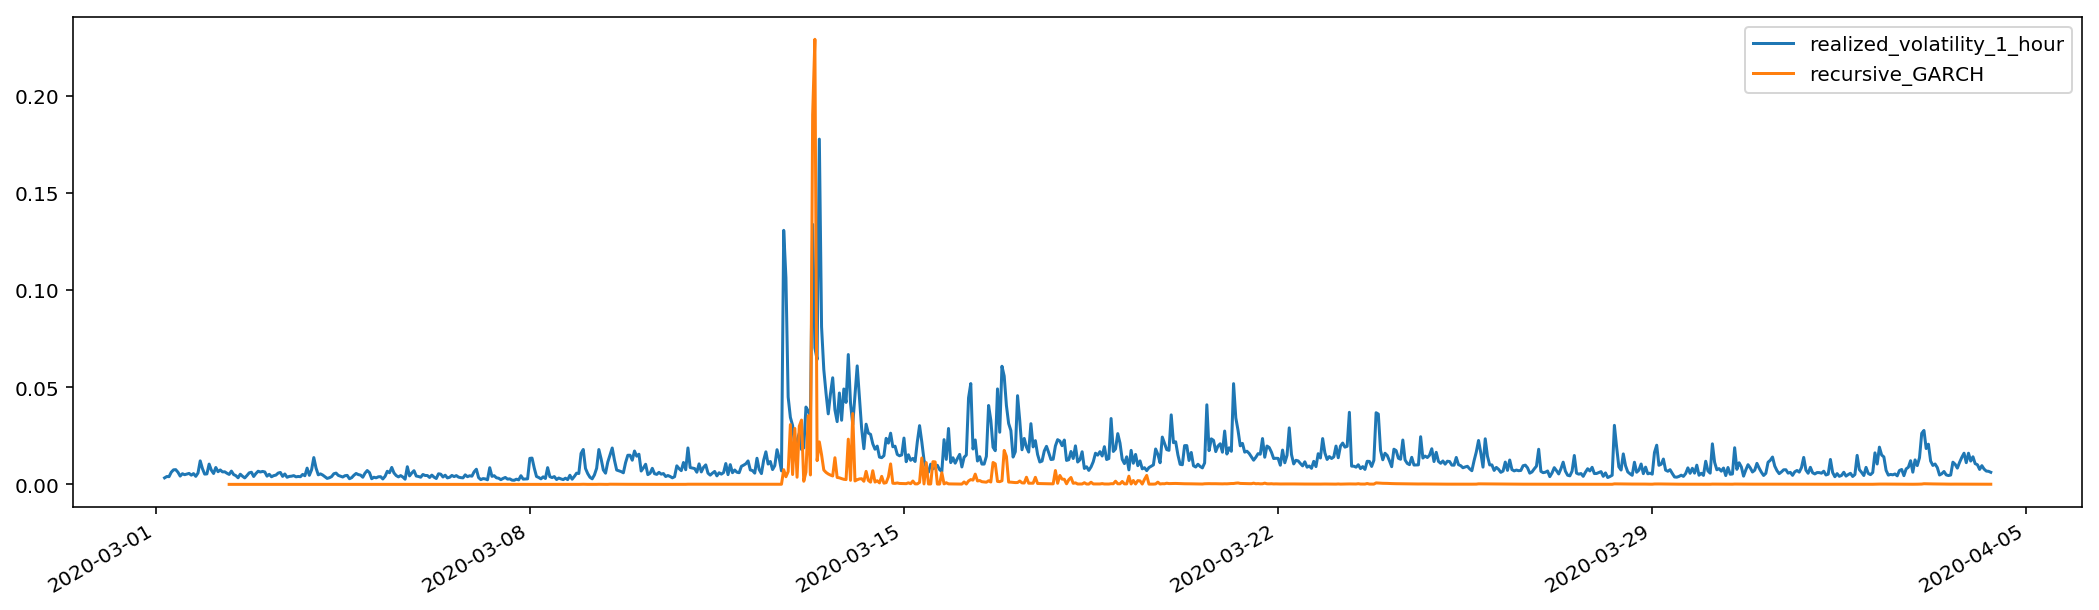

In [235]:
def recursive_forecast(pd_dataframe):     
    window = predict_lag
    model = 'GARCH'
    index = kline_test[1:].index
    end_loc = np.where(index >= kline_test.index[window])[0].min()
    forecasts = {}
    for i in range(len(kline_test[1:]) - window + 2):
        mod = arch_model(pd_dataframe['log_return'][1:], mean='AR', vol=model, dist='ged',p=1, q=1)
        res = mod.fit(last_obs=i+end_loc, disp='off', options={'ftol': 1e03})
        temp = res.forecast().variance
        fcast = temp.iloc[i + end_loc - 1]
        forecasts[fcast.name] = fcast

    forecasts = pd.DataFrame(forecasts).T
    pd_dataframe['recursive_{}'.format(model)] = forecasts['h.1']
    evaluate(pd_dataframe, 'realized_volatility_1_hour', 'recursive_{}'.format(model))

recursive_forecast(kline_test)

## 第十步 建立EGARCH模型

In [242]:
# am_EGARCH = arch_model(training_egarch, mean='AR',vol='EGARCH',
#                        p=model_lags,lags=model_lags, o=1,q=1, dist='ged',power = 2)
am_EGARCH = arch_model(training_egarch, mean='AR', vol='EGARCH', 
                       p=1, lags=model_lags, o=1,q=1, dist='ged')
res_EGARCH = am_EGARCH.fit(disp=False, options={'ftol': 1e-01})
res_EGARCH.summary()

Iteration:      1,   Func. Count:     11,   Neg. LLF: -2521.345832001941


<class 'statsmodels.iolib.summary.Summary'>
"""
                                AR - EGARCH Model Results                                 
==========================================================================================
Dep. Variable:                         log_return   R-squared:                       0.008
Mean Model:                                    AR   Adj. R-squared:                  0.004
Vol Model:                                 EGARCH   Log-Likelihood:                2521.71
Distribution:      Generalized Error Distribution   AIC:                          -5025.42
Method:                        Maximum Likelihood   BIC:                          -4983.06
                                                    No. Observations:                  818
Date:                            Sat, Apr 18 2020   Df Residuals:                      809
Time:                                    09:27:24   Df Model:                            9
                                    Mean Model                                   
=================================================================================
                     coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------------------------
Const         -6.6690e-04  5.823e-04     -1.145      0.252 [-1.808e-03,4.744e-04]
log_return[1]     -0.0906  5.905e-02     -1.535      0.125    [ -0.206,2.512e-02]
log_return[2]     -0.0220  4.685e-02     -0.469      0.639    [ -0.114,6.986e-02]
log_return[3] -4.7081e-03  4.554e-02     -0.103      0.918 [-9.397e-02,8.456e-02]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega         -0.1602  9.384e-02     -1.708  8.772e-02  [ -0.344,2.368e-02]
alpha[1]       0.1000  4.119e-02      2.428  1.516e-02  [1.929e-02,  0.181]
gamma[1]      -0.1000  3.088e-02     -3.238  1.205e-03 [ -0.161,-3.946e-02]
beta[1]        0.9800  1.150e-02     85.251      0.000    [  0.957,  1.003]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             1.5000      0.339      4.429  9.466e-06 [  0.836,  2.164]
========================================================================

Covariance estimator: robust
"""

In [195]:
temp = res_EGARCH.forecast().variance
# fcast = temp.iloc[i + end_loc - 1]
# forecasts[fcast.name] = fcast
# temp
np.mean(temp['h.1'])

0.00012891512228537866

In [243]:
res_EGARCH.params

Const           -0.000667
log_return[1]   -0.090607
log_return[2]   -0.021972
log_return[3]   -0.004708
omega           -0.160232
alpha[1]         0.100022
gamma[1]        -0.099983
beta[1]          0.980000
nu               1.500000
Name: params, dtype: float64

In [244]:
fig = res_EGARCH.hedgehog_plot(plot_type='volatility')
fig.set_size_inches(18, 4)
plt.tight_layout()
sns.despine()

KeyboardInterrupt: 

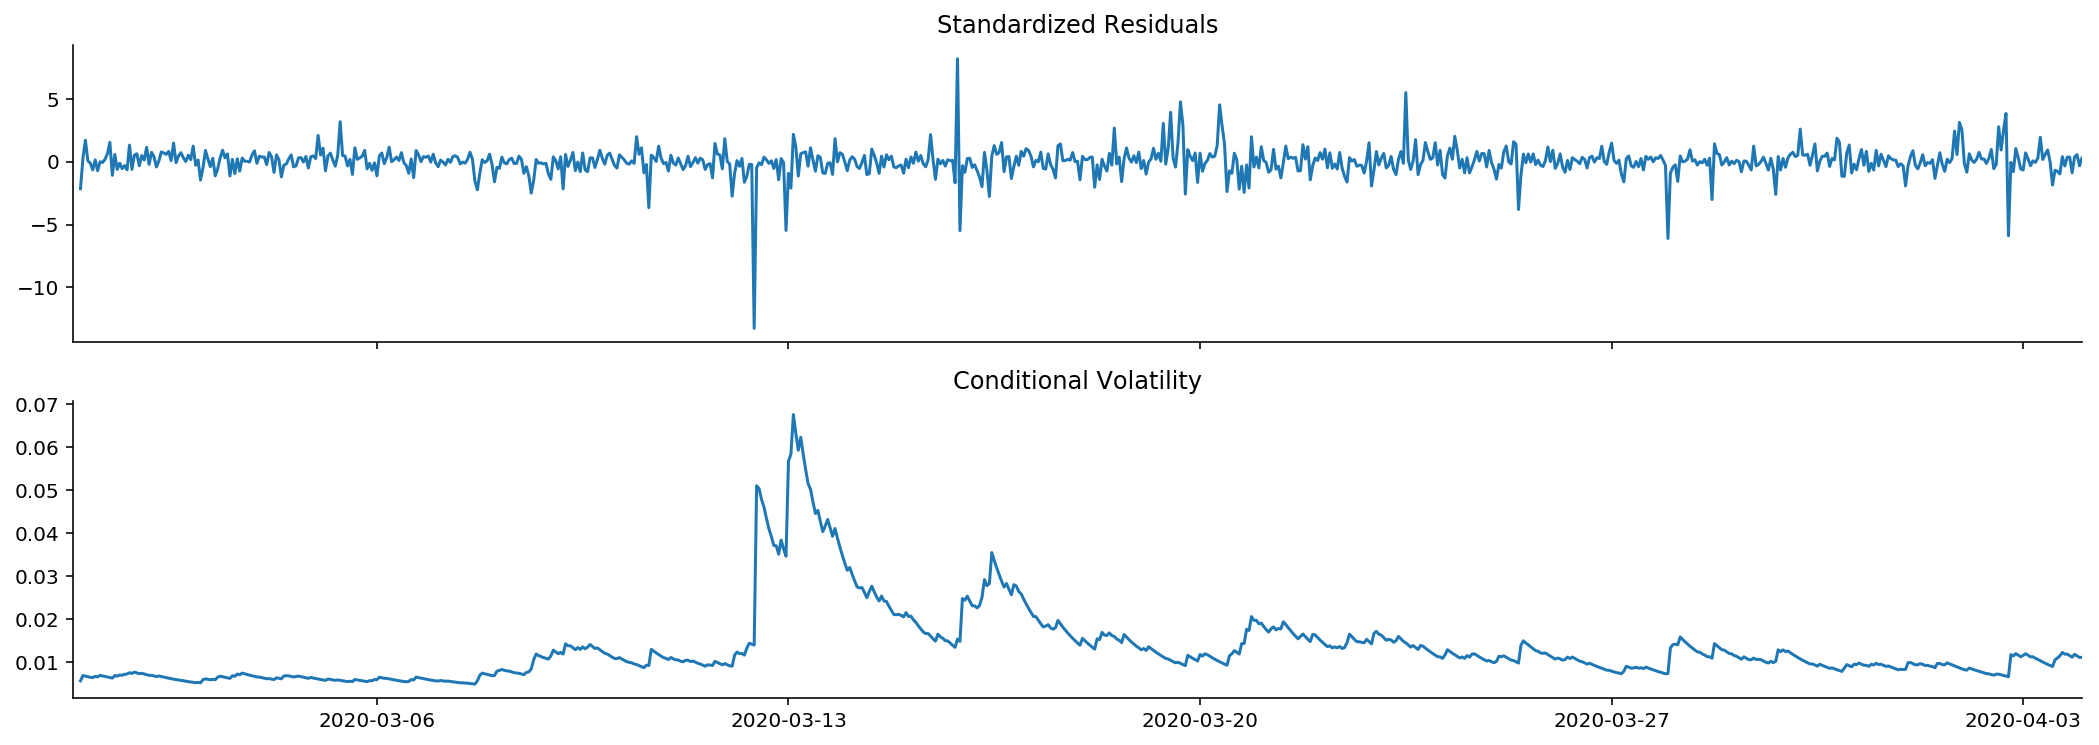

In [245]:
fig = res_EGARCH.plot()# standardized residual
fig.set_size_inches(18, 6)# conditional volatility
sns.despine()

#### EGARCH预测

Mean Absolute Error (MAE): 0.0178
Mean Absolute Percentage Error (MAPE): 122
Root Mean Square Error (RMSE): 0.0268


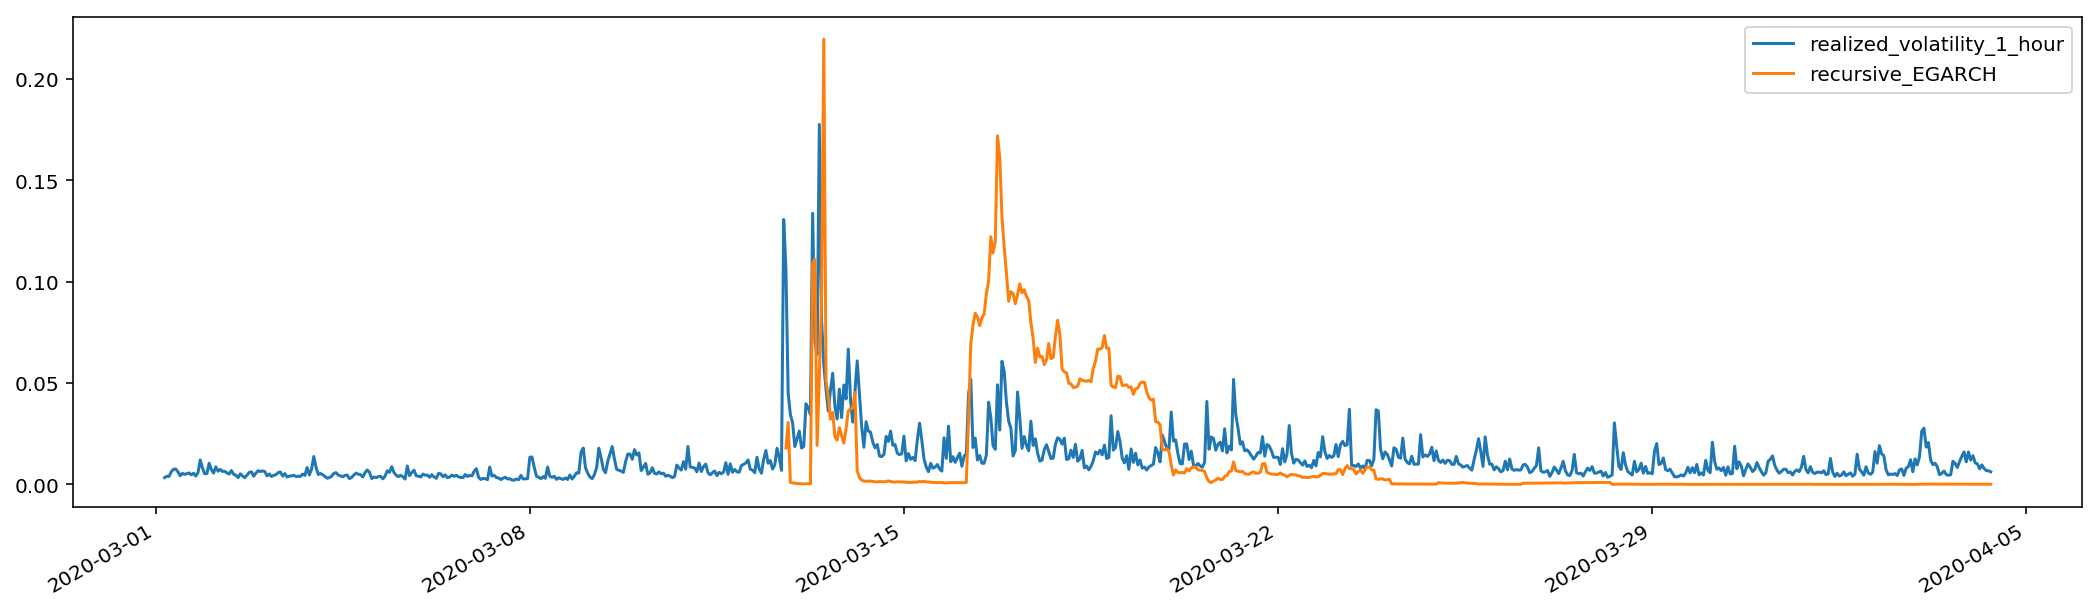

In [259]:
def recursive_forecast(pd_dataframe):     
    window = 280
    model = 'EGARCH'
    index = kline_test[1:].index
    end_loc = np.where(index >= kline_test.index[window])[0].min()
    forecasts = {}
    for i in range(len(kline_test[1:]) - window + 2):
        mod = arch_model(pd_dataframe['log_return'][1:], mean='AR', vol=model, 
                         lags=model_lags, p=2, o=0, q=1, dist='ged')
        res = mod.fit(last_obs=i+end_loc, disp='off', options={'ftol': 1e03})
        temp = res.forecast().variance
        fcast = temp.iloc[i + end_loc - 1]
        forecasts[fcast.name] = fcast

    forecasts = pd.DataFrame(forecasts).T
    pd_dataframe['recursive_{}'.format(model)] = forecasts['h.1']
    evaluate(pd_dataframe, 'realized_volatility_1_hour', 'recursive_{}'.format(model))
    pd_dataframe['recursive_{}'.format(model)]

recursive_forecast(kline_test)

## 第十一步 预测模型比较结果

In [112]:
kline_test[99:]

,close,log_price,return,log_return,squared_log_return,return_100x,log_return_100x,realized_variance_1_hour,realized_volatility_1_hour,recursive_ARCH,recursive_GARCH,recursive_EGARCH
date,,,,,,,,,,,,
2020-03-05 07:00:00+08:00,8750.74,9.076894,0.000085,0.000768,5.901774e-07,0.008464,0.076823,0.000017,0.004148,0.000016,0.000017,1.510935e+08
2020-03-05 08:00:00+08:00,8857.35,9.089003,0.001334,0.012109,1.466365e-04,0.133409,1.210935,0.000046,0.006763,0.000031,0.000019,9.378154e+07
2020-03-05 09:00:00+08:00,8871.01,9.090544,0.000170,0.001541,2.374786e-06,0.016955,0.154103,0.000036,0.006019,0.000017,0.000019,3.438122e+07
2020-03-05 10:00:00+08:00,8918.87,9.095925,0.000592,0.005381,2.895086e-05,0.059189,0.538060,0.000077,0.008751,0.000019,0.000019,3.211992e+07
2020-03-05 11:00:00+08:00,8870.97,9.090539,-0.000592,-0.005385,2.899940e-05,-0.059204,-0.538511,0.000035,0.005901,0.000020,0.000019,3.348868e+07
2020-03-05 12:00:00+08:00,8893.42,9.093067,0.000278,0.002528,6.388407e-06,0.027804,0.252753,0.000021,0.004556,0.000017,0.000019,9.707827e-02
2020-03-05 13:00:00+08:00,8923.55,9.096449,0.000372,0.003382,1.143909e-05,0.037195,0.338217,0.000015,0.003867,0.000018,0.000019,3.767136e+07
2020-03-05 14:00:00+08:00,8922.13,9.096290,-0.000017,-0.000159,2.532623e-08,-0.001749,-0.015914,0.000021,0.004548,0.000017,0.000018,4.861538e+07
2020-03-05 15:00:00+08:00,8897.93,9.093574,-0.000299,-0.002716,7.376884e-06,-0.029859,-0.271604,0.000014,0.003795,0.000018,0.000018,6.243177e+07


In [305]:
compare_ARCH_X = pd.DataFrame()
compare_ARCH_X['original']=kline_test['realized_volatility_1_hour']

compare_ARCH_X['arch']=kline_test['recursive_ARCH']
compare_ARCH_X['arch_diff']=compare_ARCH_X['original']-np.abs(compare_ARCH_X['arch'])

compare_ARCH_X['garch']=kline_test['recursive_GARCH']
compare_ARCH_X['garch_diff']=compare_ARCH_X['original']-np.abs(compare_ARCH_X['garch'])

compare_ARCH_X['egarch']=kline_test['recursive_EGARCH']
compare_ARCH_X['egarch_diff']=compare_ARCH_X['original']-np.abs(compare_ARCH_X['egarch'])
compare_ARCH_X = compare_ARCH_X[280:]
compare_ARCH_X.head(10)

,original,arch,arch_diff,garch,garch_diff,egarch,egarch_diff
date,,,,,,,
2020-03-12 20:00:00+08:00,0.044955,0.000145,0.044810,0.006633,0.038322,0.030627,0.014328
2020-03-12 21:00:00+08:00,0.034466,0.000156,0.034310,0.030780,0.003687,0.001013,0.033453
2020-03-12 22:00:00+08:00,0.030316,0.000178,0.030138,0.005083,0.025234,0.000771,0.029545
2020-03-12 23:00:00+08:00,0.018726,0.000148,0.018578,0.028795,-0.010069,0.000602,0.018123
2020-03-13 00:00:00+08:00,0.022446,0.000149,0.022297,0.003698,0.018748,0.000469,0.021977
2020-03-13 01:00:00+08:00,0.026354,0.000145,0.026209,0.029950,-0.003595,0.000370,0.025984
2020-03-13 02:00:00+08:00,0.017982,0.000184,0.017798,0.033103,-0.015121,0.000326,0.017656
2020-03-13 03:00:00+08:00,0.018783,0.000152,0.018631,0.001619,0.017164,0.000303,0.018480
2020-03-13 04:00:00+08:00,0.039796,0.000407,0.039389,0.006378,0.033419,0.000350,0.039446


In [306]:
compare_ARCH_X_diff = pd.DataFrame(index=['ARCH','GARCH','EGARCH'], columns=['head 1 step', 'head 10 steps', 'head 100 steps'])
compare_ARCH_X_diff['head 1 step']['ARCH'] = compare_ARCH_X['arch_diff']['2020-03-12 20:00:00+08:00']
compare_ARCH_X_diff['head 10 steps']['ARCH'] = np.mean(compare_ARCH_X['arch_diff'][:10])
compare_ARCH_X_diff['head 100 steps']['ARCH'] = np.mean(compare_ARCH_X['arch_diff'][:100])
compare_ARCH_X_diff['head 1 step']['GARCH'] = compare_ARCH_X['garch_diff']['2020-03-12 20:00:00+08:00']
compare_ARCH_X_diff['head 10 steps']['GARCH'] = np.mean(compare_ARCH_X['garch_diff'][:10])
compare_ARCH_X_diff['head 100 steps']['GARCH'] = np.mean(compare_ARCH_X['garch_diff'][:100])
compare_ARCH_X_diff['head 1 step']['EGARCH'] = compare_ARCH_X['egarch_diff']['2020-03-12 20:00:00+08:00']
compare_ARCH_X_diff['head 10 steps']['EGARCH'] = np.mean(compare_ARCH_X['egarch_diff'][:10])
compare_ARCH_X_diff['head 100 steps']['EGARCH'] = np.abs(np.mean(compare_ARCH_X['egarch_diff'][:100]))
compare_ARCH_X_diff

,head 1 step,head 10 steps,head 100 steps
ARCH,0.0448095,0.0289752,0.0291159
GARCH,0.0383218,0.0110186,0.0202265
EGARCH,0.0143276,0.0256362,0.000953657


In [296]:
# 评价MSE，0的MSE是估计器将以完美的精度预测参数的观测值，这将是一个理想的场景但通常不可能。
compare_ARCH_X = pd.DataFrame()
compare_ARCH_X['Model'] = ['ARCH','GARCH','EGARCH']
compare_ARCH_X['RMSE'] = [get_rmse(kline_test['realized_volatility_1_hour'][280:320],kline_test['recursive_ARCH'][280:320]),
                          get_rmse(kline_test['realized_volatility_1_hour'][280:320],kline_test['recursive_GARCH'][280:320]),
                          get_rmse(kline_test['realized_volatility_1_hour'][280:320],kline_test['recursive_EGARCH'][280:320])]
compare_ARCH_X['MAPE'] = [get_mape(kline_test['realized_volatility_1_hour'][280:320],kline_test['recursive_ARCH'][280:320]),
                          get_mape(kline_test['realized_volatility_1_hour'][280:320],kline_test['recursive_GARCH'][280:320]),
                          get_mape(kline_test['realized_volatility_1_hour'][280:320],kline_test['recursive_EGARCH'][280:320])]
compare_ARCH_X['MASE'] = [get_mape(kline_test['realized_volatility_1_hour'][280:320],kline_test['recursive_ARCH'][280:320]),
                          get_mape(kline_test['realized_volatility_1_hour'][280:320],kline_test['recursive_GARCH'][280:320]),
                          get_mape(kline_test['realized_volatility_1_hour'][280:320],kline_test['recursive_EGARCH'][280:320])]

compare_ARCH_X

,Model,RMSE,MAPE,MASE
0,ARCH,0.052409,98.072291,98.072291
1,GARCH,0.049028,80.942961,80.942961
2,EGARCH,0.040631,68.884502,68.884502


In [302]:
delta_arch = compare_ARCH_X['arch'] - compare_ARCH_X['original']
adjR_arch = 1 - delta_arch.var()/compare_ARCH_X['original'].var()

delta_garch = compare_ARCH_X['garch'] - compare_ARCH_X['original']
adjR_garch = 1 - delta_garch.var()/compare_ARCH_X['original'].var()

delta_egarch = compare_ARCH_X['egarch'] - compare_ARCH_X['original']
adjR_egarch = 1 - delta_egarch.var()/compare_ARCH_X['original'].var()

vo_adjR_test=pd.DataFrame(index=['ARCH','GARCH','EGARCH'],columns=['adjR2'])
vo_adjR_test['adjR2']['ARCH']=adjR_arch**2
vo_adjR_test['adjR2']['GARCH']=adjR_garch**2
vo_adjR_test['adjR2']['EGARCH']=adjR_egarch**2
vo_adjR_test

,adjR2
ARCH,0.00420911
GARCH,5.45136e-06
EGARCH,6.41701
